In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

from tqdm import tqdm

from PIL import Image
import requests

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = "/opt/ml/data/"

In [3]:
users = pd.read_csv(data_path + 'users.csv')
books = pd.read_csv(data_path + 'books.csv')
train = pd.read_csv(data_path + 'train_ratings.csv')
test = pd.read_csv(data_path + 'test_ratings.csv')

In [4]:
print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('ratings shape: ', train.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
ratings shape:  (306795, 3)


# Users

In [5]:
users.head()

,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


age 변수에 결측값 존재

In [7]:
users.isna().sum()/len(users)

user_id     0.000000
location    0.000000
age         0.408756
dtype: float64

약 41% 로 매우 높은 비율차지 -> 결측치 보간 필요

### location

In [8]:
users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거

users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

users = users.replace('na', np.nan) # 'na' 는 결측치로 인식 X -> 결측치로 변환
users = users.replace('', np.nan) # , , , 으로 입력된 경우 -> 결측치로 변환

In [9]:
users.head()

,user_id,location,age,location_city,location_state,location_country
0,8,"timmins,ontario,canada",NaN,timmins,ontario,canada
1,11400,"ottawa,ontario,canada",49.0,ottawa,ontario,canada
2,11676,"na,na,na",NaN,NaN,NaN,NaN
3,67544,"toronto,ontario,canada",30.0,toronto,ontario,canada
4,85526,"victoria,britishcolumbia,canada",36.0,victoria,britishcolumbia,canada


In [10]:
users.isna().sum()

user_id                 0
location                0
age                 27833
location_city         122
location_state       3254
location_country     2124
dtype: int64

In [11]:
users[users['location_country'].isna()]

,user_id,location,age,location_city,location_state,location_country
2,11676,"na,na,na",NaN,NaN,NaN,NaN
6,116866,"ottawa,,",NaN,ottawa,NaN,NaN
32,115097,"seattle,,",27.0,seattle,NaN,NaN
49,245827,"albuquerque,,",NaN,albuquerque,NaN,NaN
72,226745,"humble,,",38.0,humble,NaN,NaN
...,...,...,...,...,...,...
67797,257311,"lisbon,maine,",36.0,lisbon,maine,NaN
67929,267240,"houston,,",NaN,houston,NaN,NaN
67930,267276,"sammamish,,",NaN,sammamish,NaN,NaN
68058,276221,"calgary,,",NaN,calgary,NaN,NaN


city 가 존재하는데 state, country 는 결측인 경우가 있음 -> 보간 가능!

In [12]:
modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values
location = users[(users['location'].str.contains('seattle'))&(users['location_country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in tqdm(modify_location):
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

100%|██████████| 2113/2113 [00:56<00:00, 37.33it/s]


In [13]:
for location in tqdm(location_list):
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

100%|██████████| 1962/1962 [00:19<00:00, 102.96it/s]


In [14]:
users.isna().sum()

user_id                 0
location                0
age                 27833
location_city         122
location_state       1132
location_country      271
dtype: int64

state 와 country 결측치 모두 많이 줄어 들었음

하지만 city 결측수와 동일해야 하는 것이 아닌가? city 를 알면 state 와 country 를 알 수 있으니까! -> 이후 확인해보았지만 아닌 케이스도 존재

In [15]:
all_cities = users['location_city'].unique()

In [ ]:
# 같은 도시인데 국가 또는 주가 여러 개인 도시 확인
strange_country = []
strange_state = []

# 시간이 오래 걸리므로 주석처리 후 필요할 때 사용
# for city in tqdm(all_cities):
#     if len(users[(users['location_city']==city)&(users['location_country'].notnull())]['location_country'].value_counts())!=1:
#         strange_country.append(city)
#     elif len(users[(users['location_city']==city)&(users['location_state'].notnull())]['location_state'].value_counts())!=1:
#         strange_state.append(city)
    

100%|██████████| 11995/11995 [02:55<00:00, 68.41it/s]


In [ ]:
print('length of strange_country:', len(strange_country))
print('length of strange_state:', len(strange_state))

length of strange_country: 647
length of strange_state: 1377


확인 결과 같은 도시더라도 국가가 다른 경우가 매우 많음을 알 수 있었음

일일히 다 확인해보기에는 그 수가 너무 방대해 예시로 몇개만 알아보자.

In [ ]:
# strange country
print('city :', strange_country[1])
users[(users['location_city']==strange_country[1])&(users['location_country'].notnull())]['location_country'].value_counts()

city : victoria


canada             249
usa                  2
unitedkingdom        2
mexico               2
australia            2
britishcolumbia      2
Name: location_country, dtype: int64

확인결과 'victoria' 라는 도시는 캐나다, 미국, 영국, 멕시코 등 많은 국가에 중복으로 들어가 있음

이런 경우는 도시만 아는 것으로 추정이 불가능함

따라서 도시 & 주 모두 알고 있지만 국가를 모르거나 여러 개인 경우를 확인해봐야 할 듯함

In [ ]:
unknown_country = []
several_country = []

# 시간이 오래 걸리므로 주석처리 후 필요할 때 사용
# for city in tqdm(all_cities):
#     if len(users[(users['location_city']==city)&(users['location_state'].notnull())&(users['location_country'].notnull())]['location_country'].value_counts())!=1:
#         several_country.append(city)
#     elif len(users[(users['location_city']==city)&(users['location_state'].notnull())&(users['location_country'].isnull())]['location_country'].value_counts())!=0:
#         unknown_country.append(city)  

100%|██████████| 11995/11995 [04:02<00:00, 49.39it/s]


In [ ]:
print('length of several_country:', len(several_country))
print('length of unknown_country:', len(unknown_country))

length of several_country: 899
length of unknown_country: 0


도시와 주를 알고 있는데도 국가가 다르게 기입된 경우가 매우 많음

예시로 몇개를 확인해보자

In [ ]:
users.loc[users['location_city']==several_country[1], ['location_city', 'location_state', 'location_country']].value_counts()

location_city  location_state   location_country
victoria       britishcolumbia  canada              247
               bc               britishcolumbia       2
               britishcolumbia  unitedkingdom         2
               tamaulipas       mexico                2
               texas            usa                   2
               victoria         australia             2
               bc               canada                1
               delaware         canada                1
dtype: int64

- CASE1 : britich columbia 주를 bc 로 줄여버림 (표기 통일 X)
- CASE2 : britich columbia 주면 캐나다인데 영국으로 들어감 (오기)
- CASE3 : 주에도 bc 가 들어가고 국가에도 britishcolumbia 로 들어감 (오기)
- CASE4 : delaware 주에는 victoria city 가 없음 (오기)

In [22]:
users.loc[users['location_city']==several_country[2], ['location_city', 'location_state', 'location_country']].value_counts()

location_city  location_state   location_country
greenwood      indiana          usa                 8
               southcarolina    usa                 6
               britishcolumbia  canada              5
               arkansas         usa                 1
               mississippi      usa                 1
               novascotia       canada              1
dtype: int64

greenwood 라는 도시를 가진 주와 국가가 너무 많음 -> 확인 결과 다 옳음

어떻게 해야할까? 일괄적인 로직으로 처리하기에는 복잡하고 소탐대실인 느낌이 들어 우선 패스하자

### vizualization

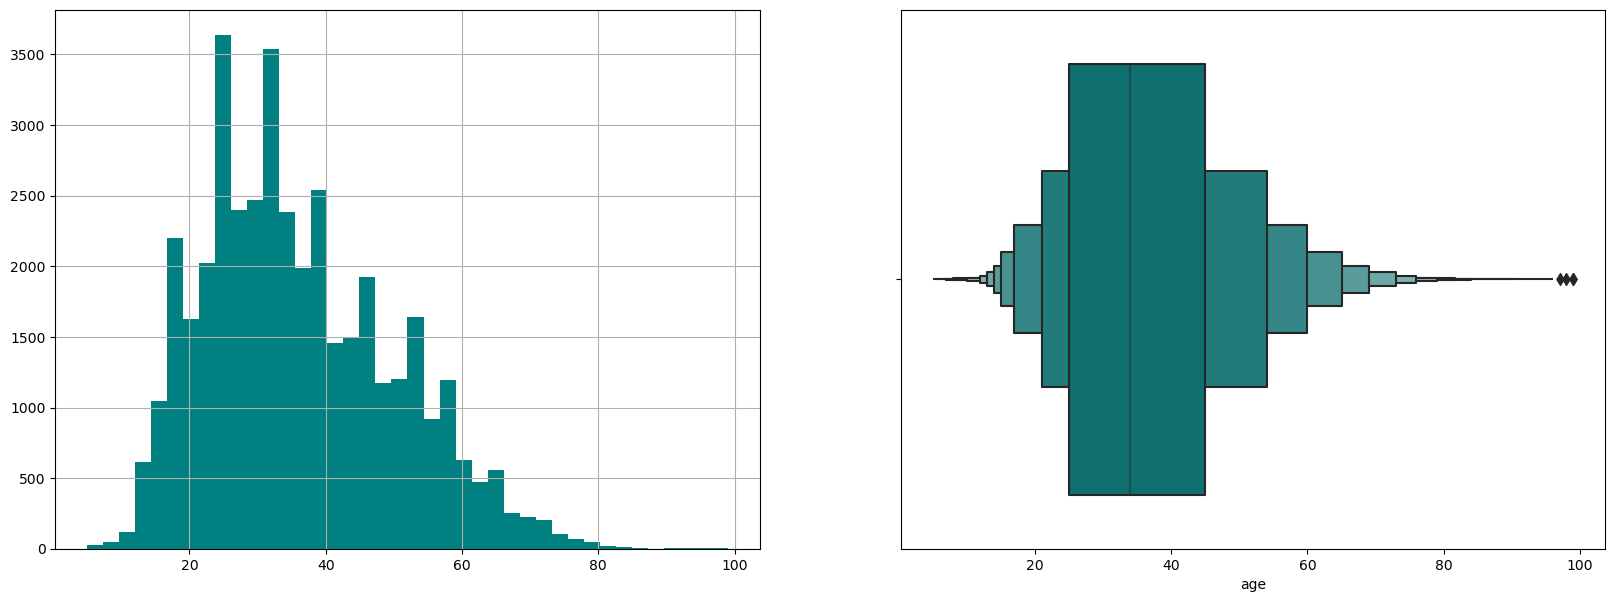

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

users['age'].hist(bins=40, color='teal', ax=ax[0])
sns.boxenplot(data=users, x='age', color='teal',ax=ax[1])

plt.show()

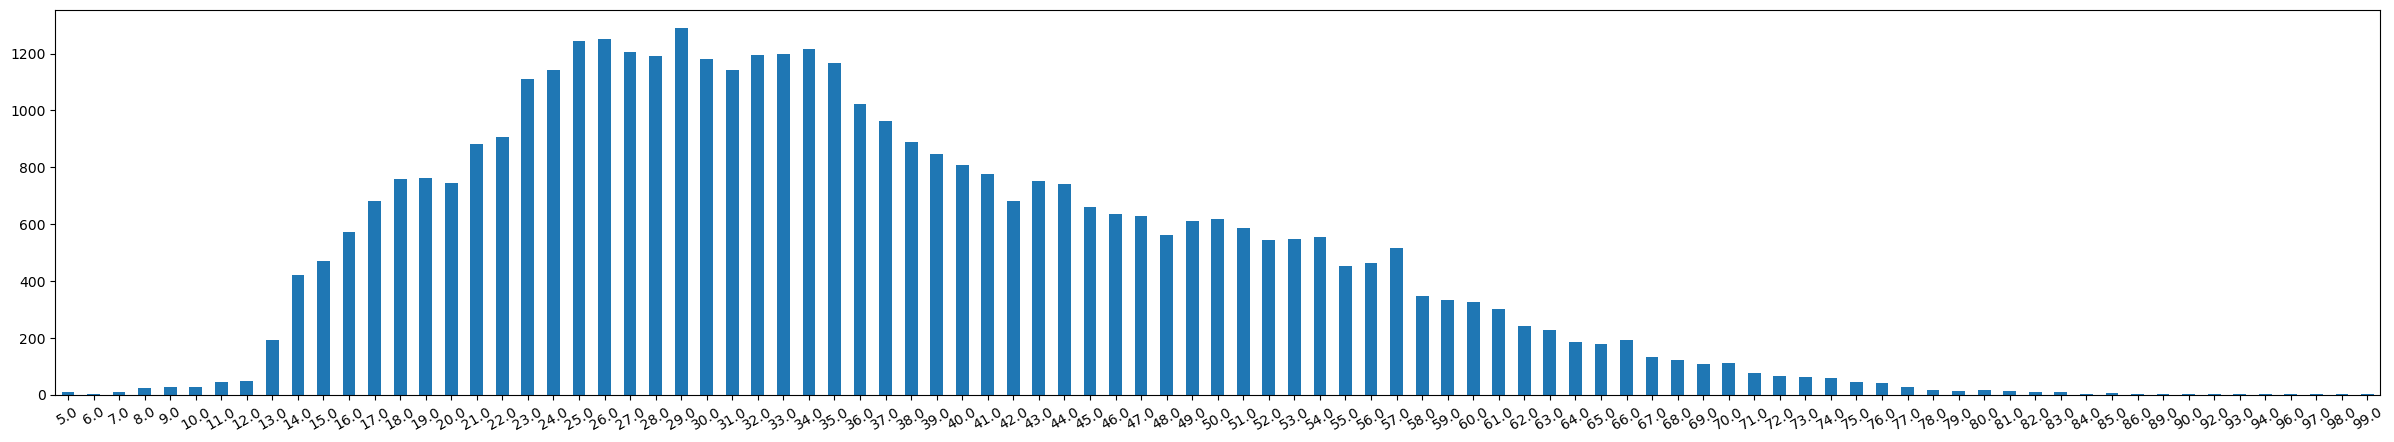

In [24]:
plt.figure(figsize=(30,5))
users['age'].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=30)
plt.show()

20 대 초중반 ~ 30대 중반 정도까지 사용자가 제일 많이 있는 듯

사용자 국가 별 분포도 확인해보자.

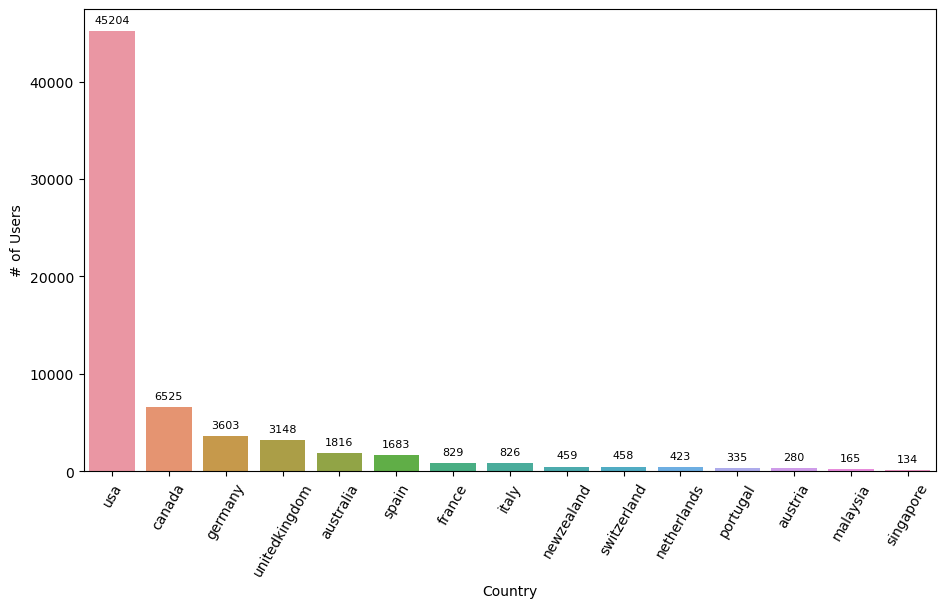

In [25]:
my_dict_country = (users['location_country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict_country.items()),columns = ['location_country','count'])
f_country = count.sort_values(by=['count'], ascending = False)
f_country = f_country.head(15)
# f.drop(7,inplace=True)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'location_country' , data = f_country)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show()

대다수가 미국에 거주 중, 그럼 미국 내에서 어떤 주에 가장 많이 거주하는 지 살펴보자

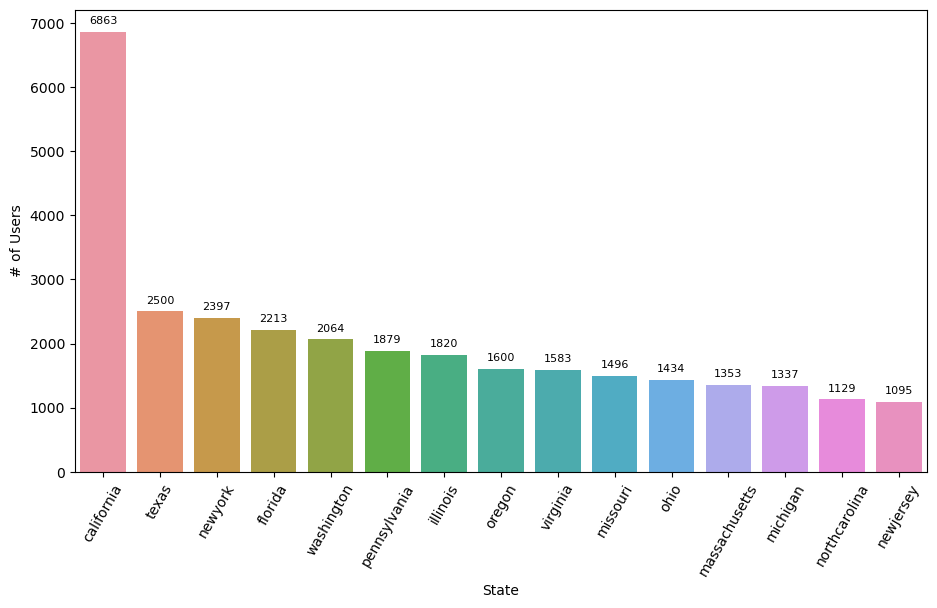

In [26]:
my_dict_state = (users.loc[users['location_country']=='usa', 'location_state'].value_counts()).to_dict()
count = pd.DataFrame(list(my_dict_state.items()),columns = ['location_state','count'])
f_state = count.sort_values(by=['count'], ascending = False)
f_state = f_state.head(15)
# f.drop(7,inplace=True)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'location_state' , data = f_state)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("State", size=10)
plt.ylabel("# of Users", size=10)
plt.show()

캘리포니아 주 거주자가 비교적 많음

국가별 사용자 나이대도 알아보자

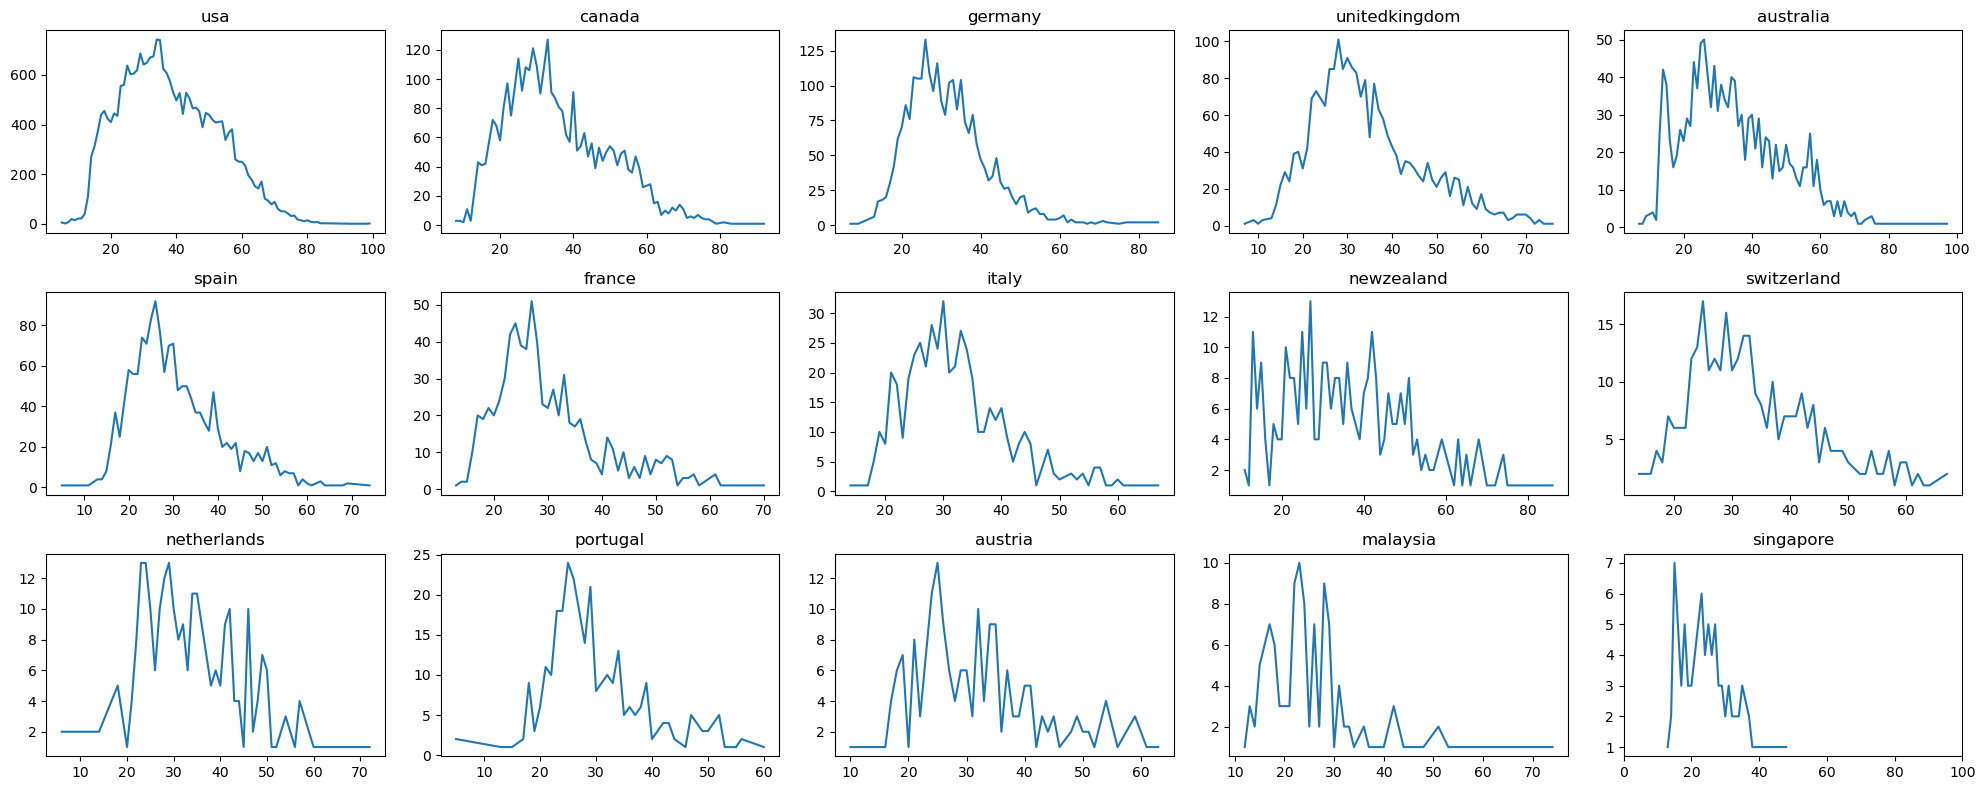

In [27]:
fig, ax = plt.subplots(3,5,figsize=(20,8))
for country, ax_ in zip(f_country['location_country'], ax.flatten()):
    users[(users['location_country']==country)]['age'].value_counts().sort_index().plot(ax=ax_, title=country)
plt.xlim(0,100)
plt.tight_layout()
plt.show()

몇몇 국가의 저년층 대비 고령층의 차이를 제외하고는 큰 차이가 보이진 않음

미국 주 별로도 관찰해보자

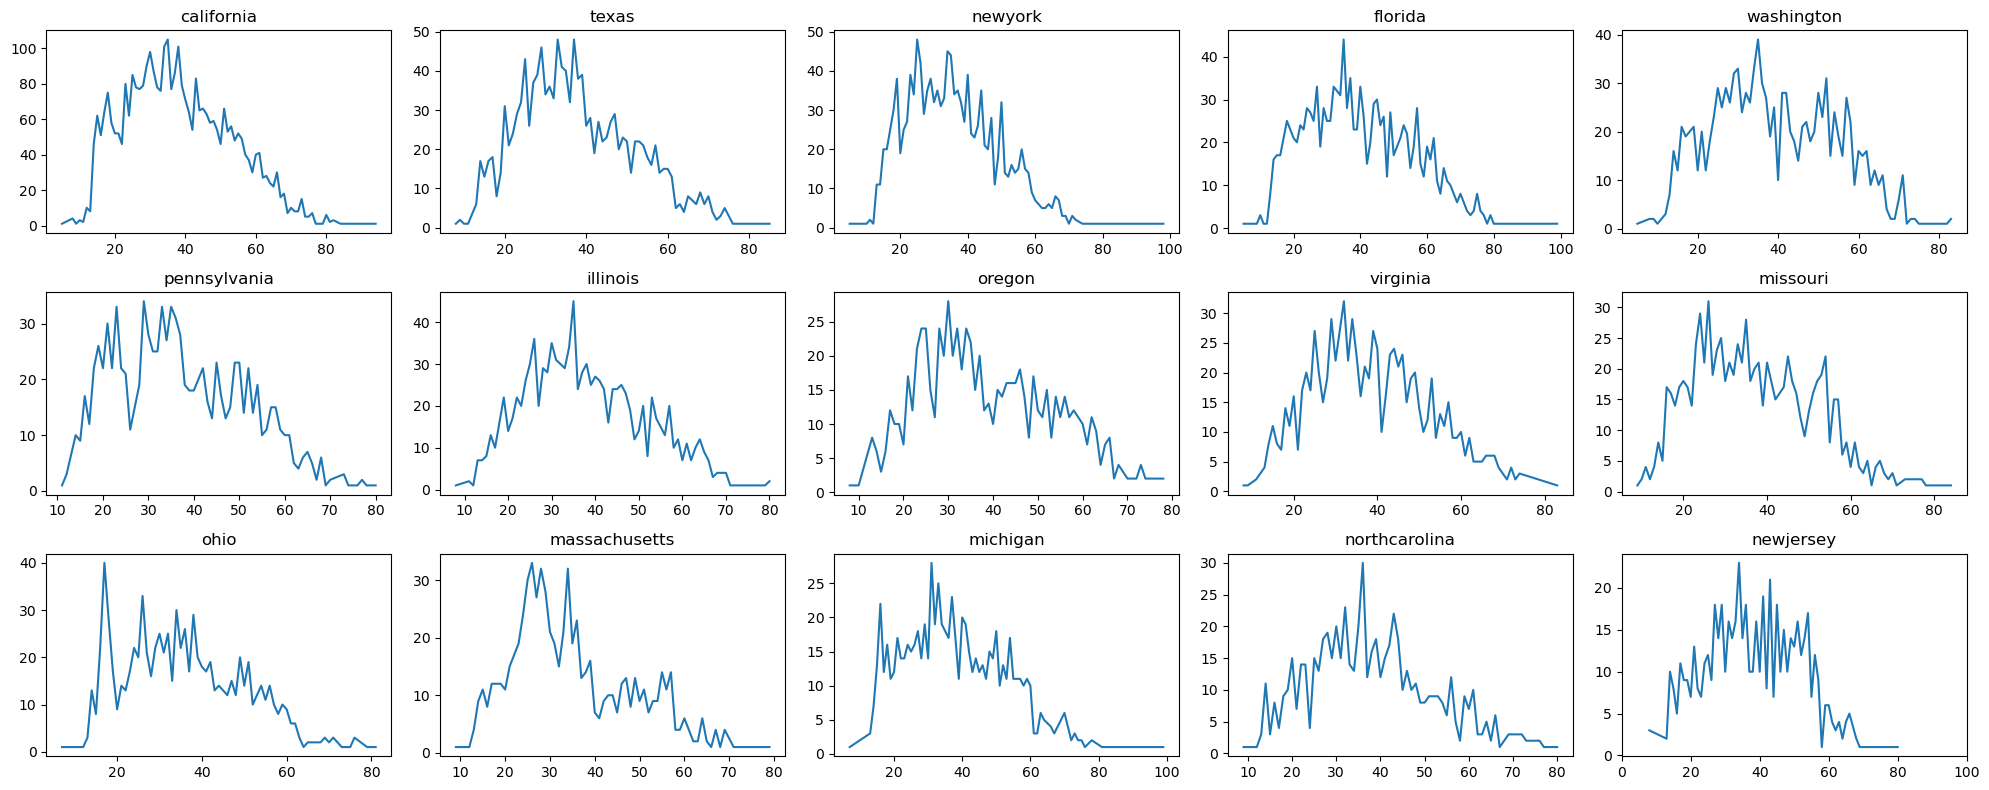

In [28]:
fig, ax = plt.subplots(3,5,figsize=(20,8))
for state, ax_ in zip(f_state['location_state'], ax.flatten()):
    users[(users['location_state']==state)]['age'].value_counts().sort_index().plot(ax=ax_, title=state)
plt.xlim(0,100)
plt.tight_layout()
plt.show()

마찬가지로 크게 눈에 띄는 차이는 없음

### Age

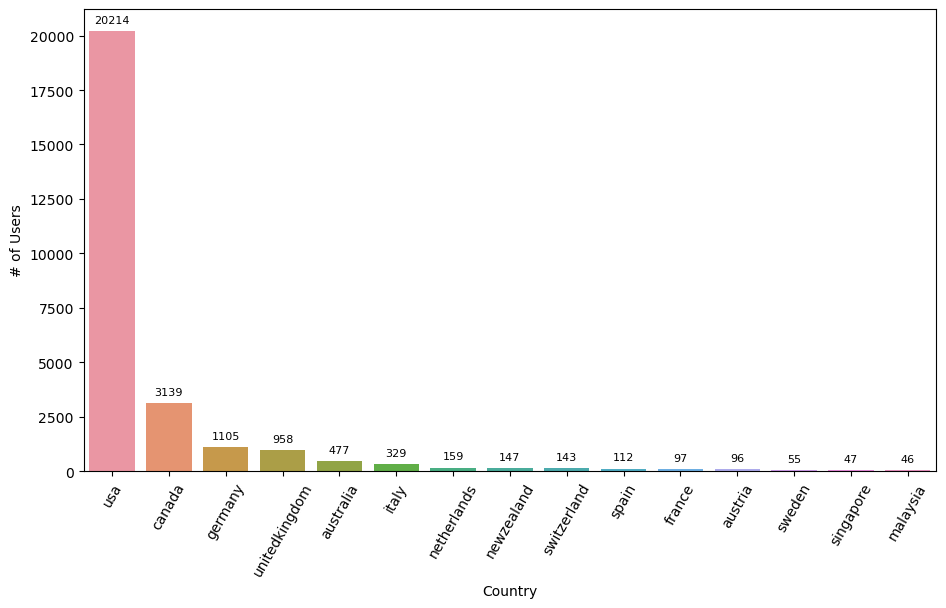

In [29]:
my_dict=(users[users['age'].isna()]['location_country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['location_country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'location_country' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show()

국가별 사용자 분포와 비교해보았을 때 특정 국가에 결측치가 몰려있지 않고 골고루 퍼져있는 듯 함

결측치를 어떻게 채우는 것이 좋을까?

- CASE1 : 모델로 결측치 채우기
- CASE2 : 중앙값, 최빈값으로 채우기
- CASE3 : 결측치 자체로 가져가기

개인적으로는 데이터가 꽤나 충분한 편이니 모델로 결측치를 대체하는 것도 괜찮을 것 같다는 생각이 듬

이 때 생길 수 있는 이슈로는 imbalacned problem 이 있음, 즉 저년층과 고령층이 많이 없기 때문에 모델의 결측치 또한 저년층과 고령층으로 잘 대체되지 않는 경향을 보일 것

- 해결방안 : down-sampling / over-sampling (SMOTE ; 카테고리컬 타입 변환 필요)

또한 조금 더 쉽게 쉽게 가려면 나이를 나이대 (10대, 20대) 로 변환하는 것도 하나의 방법이 될 듯 함

In [30]:
users = users.drop(columns='location') # 변환이 끝난 location 변수 제거

# Books

In [31]:
books.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,en,['1940-1949'],"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,['Medical'],"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg
3,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,en,['Fiction'],A Chinese immigrant who is convinced she is dy...,images/0399135782.01.THUMBZZZ.jpg
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,['History'],"Essays by respected military historians, inclu...",images/0425176428.01.THUMBZZZ.jpg


In [32]:
books.shape

(149570, 10)

In [33]:
books['isbn'].nunique()

149570

책의 고유코드는 중첩되는 것이 없음을 알 수 있음

In [34]:
books['book_title'].nunique()

135436

책 제목은 중복이 꽤나 존재하긴 함 -> 같은 제목의 책이지만 출판사가 다르다는 등의 이유

In [35]:
books.isna().sum() / len(books)

isbn                   0.000000
book_title             0.000000
book_author            0.000000
year_of_publication    0.000000
publisher              0.000000
img_url                0.000000
language               0.449468
category               0.460326
summary                0.449468
img_path               0.000000
dtype: float64

'language', 'category', 'summary' 변수의 결측이 많이 존재함, 거의 절반에 육박

주목할 점은 language 와 summary 의 결측비율이 같음

In [36]:
books[books['language'].notnull() & books['summary'].isna()]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


In [37]:
books[books['summary'].notnull() & books['language'].isna()]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


즉 language 결측 <-> summary 결측 관계가 성립

In [38]:
books[books['language'].notnull() & books['category'].isna()] 

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
138,2070567842,Folio Junior: L'histoire De Monsieur Sommer,Su>skind-Sempe,1994.0,Gallimard-Jeunesse,http://images.amazon.com/images/P/2070567842.0...,fr,NaN,Un petit garçon se pose énormément de question...,images/2070567842.01.THUMBZZZ.jpg
193,3596292646,Das Buch der lÃ?Â¤cherlichen Liebe.,Milan Kundera,2000.0,"Fischer (Tb.), Frankfurt",http://images.amazon.com/images/P/3596292646.0...,de,NaN,Die im &#39;Buch der lächerlichen Liebe&#39; v...,images/3596292646.01.THUMBZZZ.jpg
486,0871131811,Zodiac: The Eco-Thriller,Neal Stephenson,1988.0,Pub Group West,http://images.amazon.com/images/P/0871131811.0...,en,NaN,"Sangamon Taylor, an environmental extremist, s...",images/0871131811.01.THUMBZZZ.jpg
880,067144378X,SABLE MOON,Nancy Springer,1981.0,Pocket,http://images.amazon.com/images/P/067144378X.0...,en,NaN,Seventeen-year-old Prince Trevyn must save the...,images/067144378X.01.THUMBZZZ.jpg
1001,0345339711,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,1986.0,Del Rey,http://images.amazon.com/images/P/0345339711.0...,en,NaN,"Thus continues the magnificent, bestselling ta...",images/0345339711.01.THUMBZZZ.jpg
...,...,...,...,...,...,...,...,...,...,...
149252,3770401697,"Lucky Luke, Bd.58, Die Geister-Ranch und ander...",Michel Janvier,1989.0,"Egmont Ehapa, Berlin",http://images.amazon.com/images/P/3770401697.0...,de,NaN,"Enth. noch: Die Hellseherin, Die Statue und Di...",images/3770401697.01.THUMBZZZ.jpg
149307,0806917695,Perplexing Lateral Thinking Puzzles: Scholasti...,Paul Sloane,1997.0,Sterling Publishing,http://images.amazon.com/images/P/0806917695.0...,en,NaN,"Normal situations veer off into the bizarre, c...",images/0806917695.01.THUMBZZZ.jpg
149329,3426192543,Im FrÃ?Â¼hling singt zum letztenmal die Lerche.,Johannes Mario Simmel,1990.0,Droemer Knaur,http://images.amazon.com/images/P/3426192543.0...,de,NaN,Eine Gruppe von Idealisten nimmt den Kampf geg...,images/3426192543.01.THUMBZZZ.jpg
149441,2253054615,Le maharani,Gita Mehta,1990.0,LGF,http://images.amazon.com/images/P/2253054615.0...,fr,NaN,Elevée à la cour comme toutes les maharani l&#...,images/2253054615.01.THUMBZZZ.jpg


In [39]:
books[books['category'].notnull() & books['language'].isna()] 

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


- language 존재 -> category 결측일수도 아닐 수도
- language 결측 -> category 존재 X

결국 중요한건 language 의 결측 여부임, language 가 결측이면 summary 와 category 도 결측

### isbn

isbn 과 img_url, img_path 간의 유사성이 많이 보임

책의 고유번호로 url 과 path 를 구성한듯 함

아예 다 똑같은 건지 확인해보자

In [40]:
books[books['isbn'] != books['img_url'].apply(lambda x: x.split('P/')[1][:10])]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


In [41]:
books[books['isbn']!=books['img_path'].apply(lambda x: x.split('images/')[1][:10])]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


모두 동일하므로 일괄적으로 처리해도 문제 없음

isbn 은 출판 국가, 출판사 번호, 항목 번호, 확인 숫자 순서로 구성된다고 하며 확인 숫자의 경우 X 이면 10을 나타낸다고 함

이를 통해 출판사 항목의 개수를 줄일 수 있음 (출판사 번호를 통해)

In [42]:
books[books['publisher']=="Penguin Books"]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
68,0140067477,The Tao of Pooh,Benjamin Hoff,1983.0,Penguin Books,http://images.amazon.com/images/P/0140067477.0...,en,['Humor'],An expert in Chinese philosophy explains facet...,images/0140067477.01.THUMBZZZ.jpg
119,0143034359,Thursday Next in the Well Of Lost Plots (Thurs...,Fforde Jasper,2004.0,Penguin Books,http://images.amazon.com/images/P/0143034359.0...,en,['Fiction'],Exhausted by her stint as Miss Havisham&#39;s ...,images/0143034359.01.THUMBZZZ.jpg
157,0140250964,Snow Angels,Stewart O'Nan,1995.0,Penguin Books,http://images.amazon.com/images/P/0140250964.0...,en,['Fiction'],Weaves together two stories in the account of ...,images/0140250964.01.THUMBZZZ.jpg
196,0140272100,Vanished,Mary McGarry Morris,1997.0,Penguin Books,http://images.amazon.com/images/P/0140272100.0...,en,['Fiction'],Aubrey Wallace is the kind of man no one notices.,images/0140272100.01.THUMBZZZ.jpg
298,014028009X,Bridget Jones's Diary,Helen Fielding,1999.0,Penguin Books,http://images.amazon.com/images/P/014028009X.0...,en,['Fiction'],This witty national bestseller is now availabl...,images/014028009X.01.THUMBZZZ.jpg
...,...,...,...,...,...,...,...,...,...,...
149154,0140423818,Lord Byron: Selected Poems (Penguin Classics),George Gordon Byron,1996.0,Penguin Books,http://images.amazon.com/images/P/0140423818.0...,en,['Poetry'],&quot; &quot;Byron&#39;s contemporary populari...,images/0140423818.01.THUMBZZZ.jpg
149301,0140290788,Time Out Chicago (Time Out Chicago),Time Out,2000.0,Penguin Books,http://images.amazon.com/images/P/0140290788.0...,NaN,NaN,NaN,images/0140290788.01.THUMBZZZ.jpg
149345,0140182551,The Old Wives' Tale (20th Century Classics),Arnold Bennett,1990.0,Penguin Books,http://images.amazon.com/images/P/0140182551.0...,en,['Fiction'],Victorian novel set in the pottery district of...,images/0140182551.01.THUMBZZZ.jpg
149387,0140390715,The Pathfinder (Penguin Classic),James Fenimore Cooper,1989.0,Penguin Books,http://images.amazon.com/images/P/0140390715.0...,en,['Fiction'],Cooper undertakes a &quot;hazardous experiment...,images/0140390715.01.THUMBZZZ.jpg


Penguin Books 출판사의 isbn 시작번호가 0140 으로 다 같음

In [43]:
books[books['isbn'].apply(lambda x: x[:4])=='0140']['publisher'].unique()

array(['Penguin Books', 'Penguin Books Ltd', 'Puffin Books',
       'Penguin USA (Paper)', 'Penguin USA', 'Puffin',
       'Penguin Putnam~trade', 'Penguin Putnam~mass',
       'Penguin/Puffin Mass Market (Mm)', 'Viking Books',
       'Penguin Books Australia Ltd', 'Penguin Uk',
       'Scott Foresman (Pearson K-12)',
       'Penguin Putnam Books for Young Readers',
       'French & European Pubns', 'Viking Penguin', 'Arkana',
       'Penguin Highbridge Audio', 'Penguin (Non-Classics)',
       'Penguin Books, Limited (UK)', 'Viking Press', 'Penguin U S A',
       'Penguin/Puffin Mass Market', 'Select Penguin (Mm)',
       'Penguin Putnam', 'Penguin Books India', 'Select Penguin',
       'Penguin Books Australia Ltd.', 'Viking Penguin Inc',
       'Penguin Audiobooks', 'Studio Books', 'Penguin',
       'Hyperion Books for Children', 'Putnam Pub Group', 'Penguin India',
       'Compass Books', 'Penguin Putnam~childrens Hc',
       'Penguin in association with Secker and Warburg', 'Time O

하지만 0140 으로 시작하는, 즉 penguin books 의 출판사는 표기방법 이나 오타등으로 인해 다름을 알 수 있음

이를 수정해보자

In [44]:
publisher_dict=(books['publisher'].value_counts()).to_dict()
publisher_count_df= pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])

publisher_count_df = publisher_count_df.sort_values(by=['count'], ascending = False)

In [45]:
publisher_count_df.head()

,publisher,count
0,Harlequin,3005
1,Ballantine Books,2322
2,Pocket,2274
3,Penguin Books,1943
4,Bantam Books,1938


In [46]:
books['publisher'].nunique() # 수정 전 출판사 항목 수

11571

In [47]:
modify_list = publisher_count_df[publisher_count_df['count']>1].publisher.values

for publisher in tqdm(modify_list):
    try:
        number = books[books['publisher']==publisher]['isbn'].apply(lambda x: x[:4]).value_counts().index[0]
        right_publisher = books[books['isbn'].apply(lambda x: x[:4])==number]['publisher'].value_counts().index[0]
        books.loc[books[books['isbn'].apply(lambda x: x[:4])==number].index,'publisher'] = right_publisher
    except: 
        pass

100%|██████████| 5276/5276 [02:25<00:00, 36.25it/s]


In [48]:
books['publisher'].nunique() #수정 후 출판사 항목 수

1523

### category

In [49]:
import re

# category 에서 항목을 대괄호 밖으로 빼내기
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())

# 소문자로 통일
books['category'] = books['category'].str.lower()

In [50]:
category_df = pd.DataFrame(books['category'].value_counts()).reset_index()
category_df.columns = ['category','count']
category_df.head()

,category,count
0,fiction,33016
1,juvenile fiction,5835
2,biography autobiography,3326
3,history,1927
4,religion,1818


In [51]:
len(category_df)

4105

카테고리 개수 너무 많음, 특히 전기&자서전 카테고리와 전기, 자서전 카테고리가 따로 존재함

In [52]:
books['category_high'] = books['category'].copy()
books.loc[books[books['category']=='biography'].index, 'category_high'] = 'biography autobiography'
books.loc[books[books['category']=='autobiography'].index,'category_high'] = 'biography autobiography'

In [53]:
category_df[category_df['count'] >= 100]

,category,count
0,fiction,33016
1,juvenile fiction,5835
2,biography autobiography,3326
3,history,1927
4,religion,1818
5,juvenile nonfiction,1418
6,social science,1231
7,humor,1161
8,body mind spirit,1113
9,business economics,1073


실제로 100개 이상 겹치는 카테고리는 50 개

따라서 상위 카테고리로 묶어주자 -> unique 값 감소

baseline 에서 제시하는 category 들은 아래와 같지만 더 찾을 수 있을 것 같다

**조금 더 합리적인 category 를 스스로 찾아보자**

In [54]:
categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
 'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
 'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
 'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india']

len(categories)

43

In [55]:
for category in tqdm(categories):
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

100%|██████████| 43/43 [00:02<00:00, 20.79it/s]


In [56]:
category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category','count']
category_high_df.head(10)

,category,count
0,fiction,39678
1,biography autobiography,3335
2,history,1927
3,religion,1824
4,nonfiction,1427
5,humor,1291
6,social,1271
7,business,1146
8,cook,1125
9,body mind spirit,1113


In [57]:
print('# of unique before replacing:', len(category_df))
print('# of unique after replacing:', len(category_high_df))

# of unique before replacing: 4105
# of unique after replacing: 3268


unique 값이 변환을 하기 전과 크게 차이가 나지가 않으므로 카테고리가 너무 겹치지 않는 카테고리들은 others(기타)로 치환하는 것이 좋아 보임

하지만 "너무 겹치지 않는" 의 기준치를 정하는 것이 애매하므로 적절한 기준치를 찾아보자. 우선은 앞서 생각했던 100 개를 기준으로 관찰해보려한다.

In [58]:
len(category_high_df[category_high_df['count'] <= 100])/len(category_high_df)

0.9850061199510404

100개 이하로 겹치는 카테고리들이 약 99%에 육박하므로 100 은 적절한 기준이 될 수 없음.

50개는 어떨지 보자

In [59]:
len(category_high_df[category_high_df['count'] <= 50])/len(category_high_df)

0.9798041615667075

거의 차이가 없으므로 수를 확 줄여 10개 이하로 보자

In [60]:
len(category_high_df[category_high_df['count'] <= 10])/len(category_high_df)

0.9409424724602203

10개 이하도 너무 많다... 그럼 만약 10개 이하인 카테고리들을 다 합치면 몇개의 count 를 갖는지 확인해보자

In [61]:
sum(category_high_df[category_high_df['count'] <= 10]['count'])

5622

In [62]:
category_high_df.head(5)

,category,count
0,fiction,39678
1,biography autobiography,3335
2,history,1927
3,religion,1824
4,nonfiction,1427


10 개 이하로 묶으면 others 가 꽤 높은 차이로 2등이 되어버린다...

마지막으로 5 개를 확인해보자

In [63]:
len(category_high_df[category_high_df['count'] <= 5])/len(category_high_df)

0.8938188494492044

In [64]:
sum(category_high_df[category_high_df['count'] <= 5]['count'])

4474

5 개를 해도 2등 하는것은 마찬가지니까 그냥 마음편하게 10개로 줄인다음 category unique 수를 크게 줄이는게 더 좋을 듯하다

In [65]:
# 낮은 카테고리 개수 기준 = 10
others_list = category_high_df[category_high_df['count']<10]['category'].values

books.loc[books[books['category_high'].isin(others_list)].index, 'category_high']='others'

In [66]:
print('# of origin category', books['category'].nunique())
print('# of high category', books['category_high'].nunique())

# of origin category 4105
# of high category 209


category 의 unique 수가 매우 크게 줄었다!

In [67]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
category_high          68851
dtype: int64

language 의 결측을 채우려면 출판사와 국가등을 엄밀히 따져보아야 하기 때문에 아무래도 조금 어렵지 않을까? 라는 생각이 있지만 꼭 **도전 해보기**

### visualization

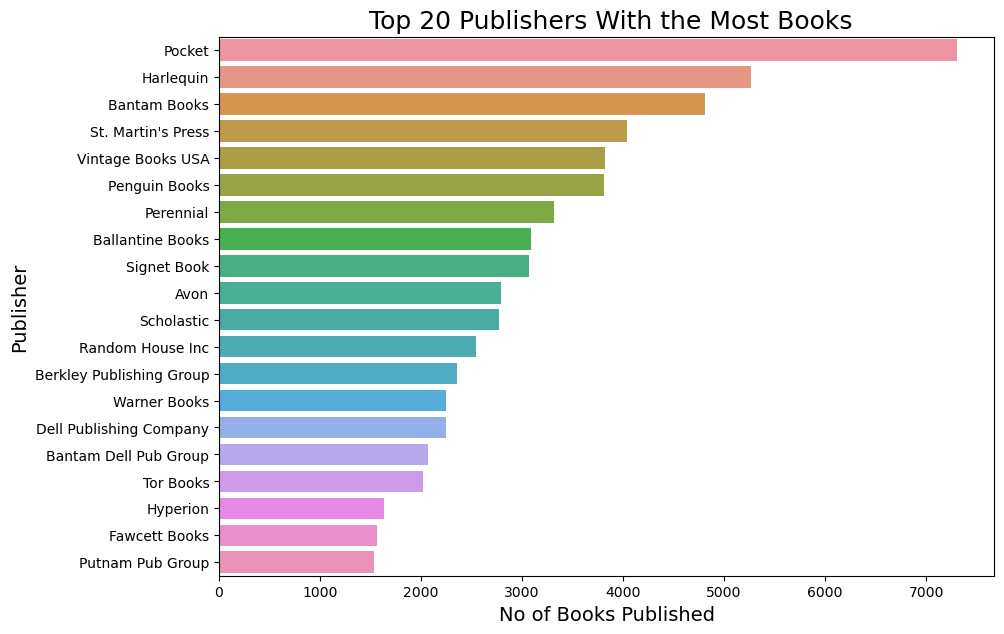

In [68]:
publisher_dict=(books['publisher'].value_counts()).to_dict()
publisher_count_df= pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])

b = publisher_count_df.sort_values(by=['count'], ascending = False)
b = b.head(20)

fig=plt.figure(figsize=(10,7))
ax = sns.barplot(x = 'count',y = 'publisher' , data = b)

plt.xlabel("No of Books Published", size=14)
plt.ylabel("Publisher", size=14)
plt.title(" Top 20 Publishers With the Most Books", size=18)

plt.show()

상위 20개의 출판사 중 압도적으로 많이 출판하는 출판사는 Pocket 을 제외하고는 딱히 없는 것 같다.

**출판사를 통해 language 결측치를 대체할 수 있을까?**

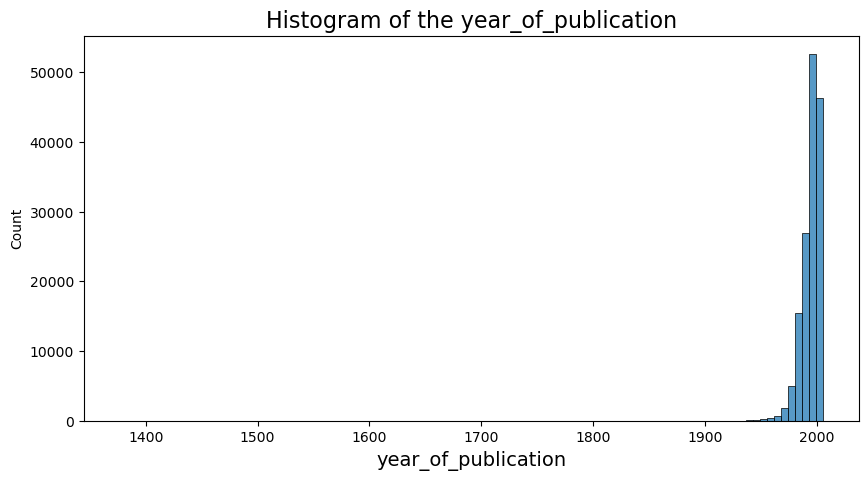

In [69]:
plt.figure(figsize=(10,5))
sns.histplot(books['year_of_publication'],bins=100)
plt.xlabel('year_of_publication',size=14)
plt.title('Histogram of the year_of_publication',size=16)
plt.show()

출간연도를 확인해보니 뭔가 이상하다. 1400 년도는 뭐지?

In [70]:
books['year_of_publication'].value_counts().sort_index()

1376.0        1
1378.0        1
1806.0        1
1900.0        1
1901.0        4
          ...  
2002.0    11669
2003.0     9430
2004.0     3771
2005.0       19
2006.0        1
Name: year_of_publication, Length: 95, dtype: int64

확인결과 1376 년과 1378 년에 출간된 책이 두 권이 존재한다. 

이상치로 의심되므로 해당 데이터를 살펴보자

In [71]:
books[books['year_of_publication'].isin([1376.0, 1378.0])]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,category_high
104259,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378.0,Intisharat-i Quqnus,http://images.amazon.com/images/P/9643112136.0...,fa,fantasy fiction,"Mahnaz, the only daughter of a traditional ari...",images/9643112136.01.THUMBZZZ.jpg,fiction
121860,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376.0,Nashr-i Alburz,http://images.amazon.com/images/P/964442011X.0...,NaN,NaN,NaN,images/964442011X.01.THUMBZZZ.jpg,NaN


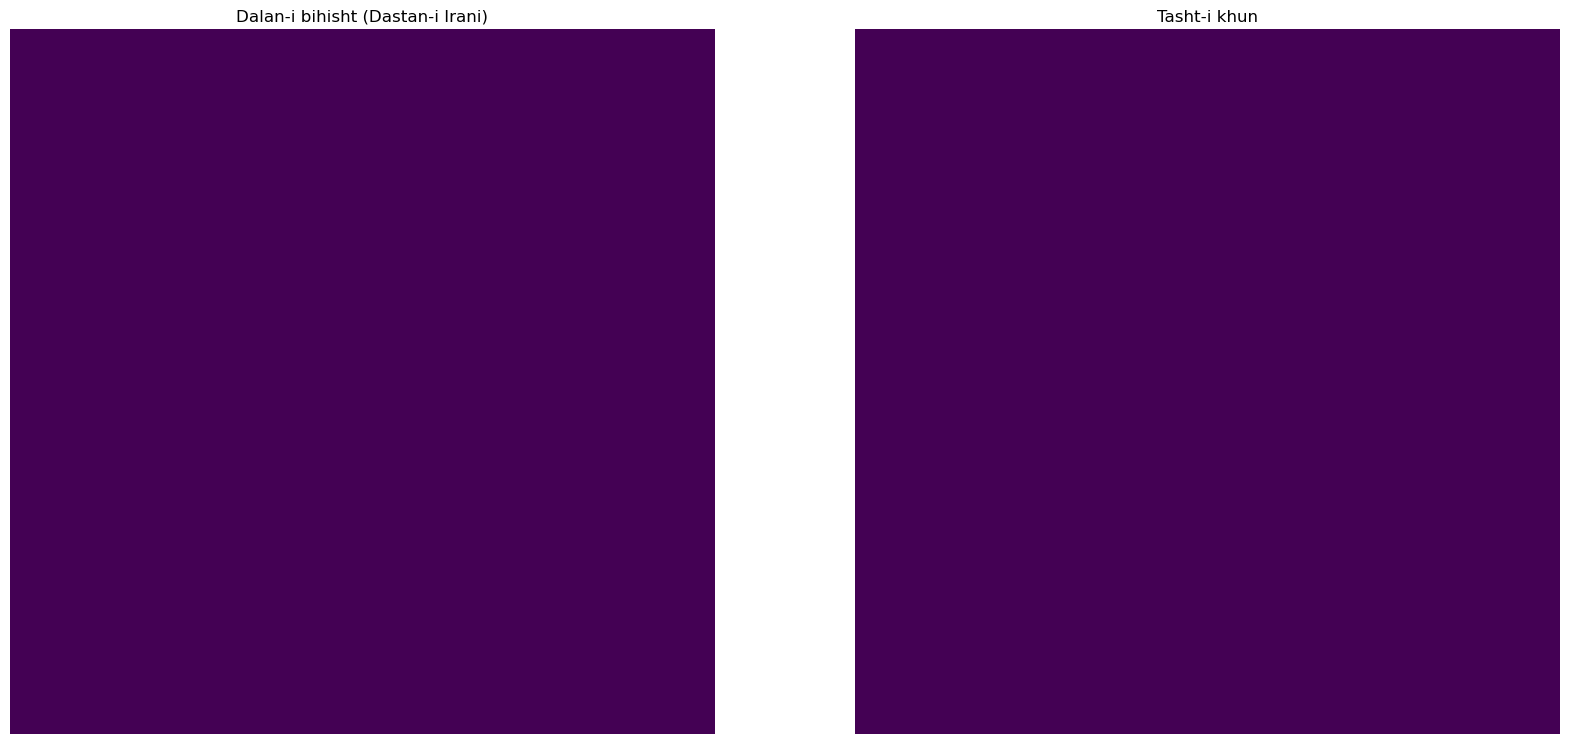

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10)) 
for i, ax in zip([104259, 121860], ax.flatten()):
    url = books['img_url'][i]
    img = np.asarray(Image.open(requests.get(url, stream=True, headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}).raw))
    ax.imshow(img)
    ax.axis("off")
 
    ax.set_title(books['book_title'][i])

fig.show()

url 을 통해서 보니 확인이 되지도 않으니 주어진 image 데이터에서 확인해보았는데, 사진이 존재하지 않음

검색을 해서 확인해보니 다음과 같음

- *Dalan-i bihisht (Dastan-i Irani)* : 2010 년
- *Tasht-i khun* : 1997 년

따라서 수정해주자

In [73]:
books.loc[104259, 'year_of_publication'] = 2010.0
books.loc[121860, 'year_of_publication'] = 1997.0

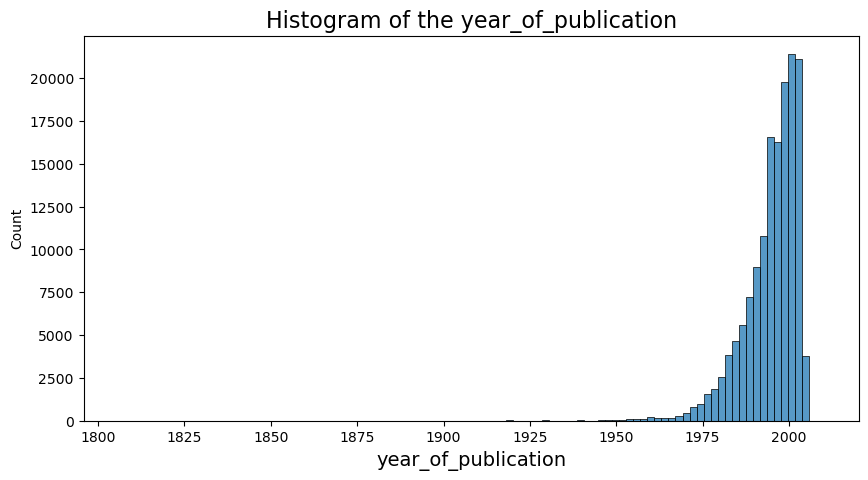

In [74]:
plt.figure(figsize=(10,5))
sns.histplot(books['year_of_publication'],bins=100)
plt.xlabel('year_of_publication',size=14)
plt.title('Histogram of the year_of_publication',size=16)
plt.show()

정상적으로 대체되었음을 알 수 있음, 그래도 1800 년대 책이 조금 걸리긴 하니 확인해보자

In [76]:
books[books['year_of_publication'] < 1900]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,category_high
129205,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable...",Benjamin Franklin,1806.0,Hippocrene Books,http://images.amazon.com/images/P/0781228956.0...,en,NaN,Bonded Leather binding,images/0781228956.01.THUMBZZZ.jpg,NaN


1806 년도 책은 아닌것 같은데 자료를 찾기 힘들고 찾아도 다 달라서 일단 keep

**여차하면 그냥 drop 해도 될것 같음**

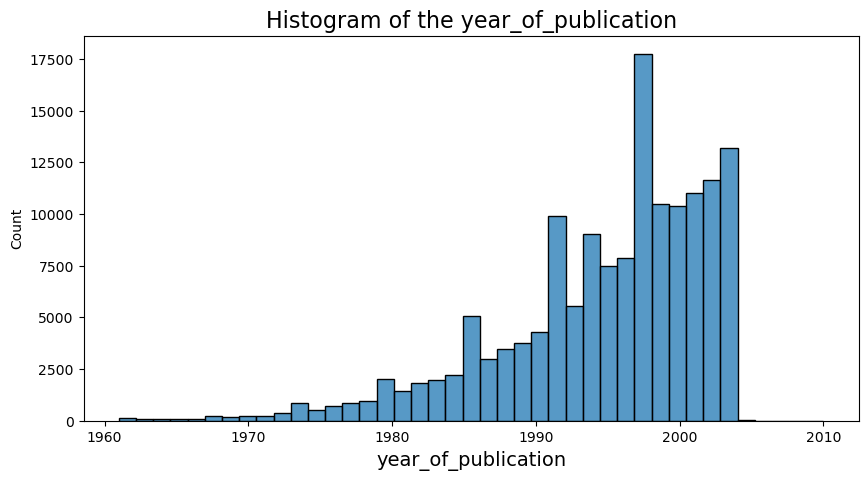

In [75]:
plt.figure(figsize=(10,5))
sns.histplot(books[books['year_of_publication']>1960]['year_of_publication'],bins=41)
plt.xlabel('year_of_publication',size=14)
plt.title('Histogram of the year_of_publication',size=16)
plt.show()

대부분의 책들은 1970 년도 이후, 특히 1980 년도 이후에 출판된 듯 함

# Ratings

In [82]:
train.head()

,user_id,isbn,rating
0,8,0002005018,4
1,67544,0002005018,7
2,123629,0002005018,8
3,200273,0002005018,8
4,210926,0002005018,9


In [83]:
train['user_id'].nunique()

59803

In [84]:
train.shape

(306795, 3)

유저가 여러번 평가한 것 까지 포함되어 있음

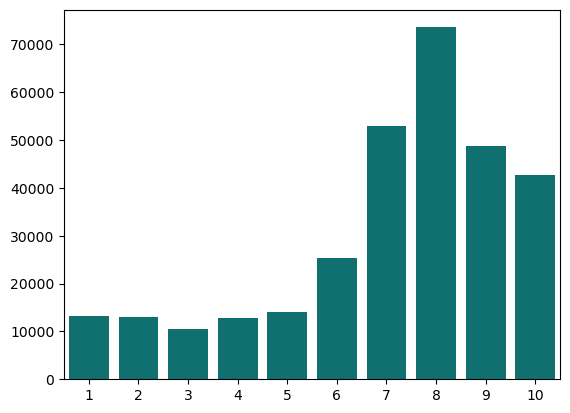

In [88]:
rating_values = train['rating'].value_counts()
sns.barplot(x=rating_values.index, y=rating_values.values, color='teal')
plt.show()

baseline 코드와 다르게 평점 1이 많이 존재 하지 않으며 7~9 점이 많이 존재함

### visualization

In [90]:
train.groupby('user_id')['rating'].count().sort_values(ascending=False)

user_id
11676     5520
98391     4560
189835    1503
153662    1496
23902      956
          ... 
47317        1
150670       1
150676       1
150677       1
138957       1
Name: rating, Length: 59803, dtype: int64

1 권 읽은 유저부터 5520 권까지 스케일이 넓게 분포되어 있음

헤비 유저 20명을 뽑아서 그 들의 평점을 시각화해보자

만약 유의미한 차이가 있다면 책을 읽은 개수를 변수로 사용할 수도 있을 것임

In [91]:
heavy_users_list = train.groupby('user_id')['rating'].count().sort_values(ascending=False).head(20).index

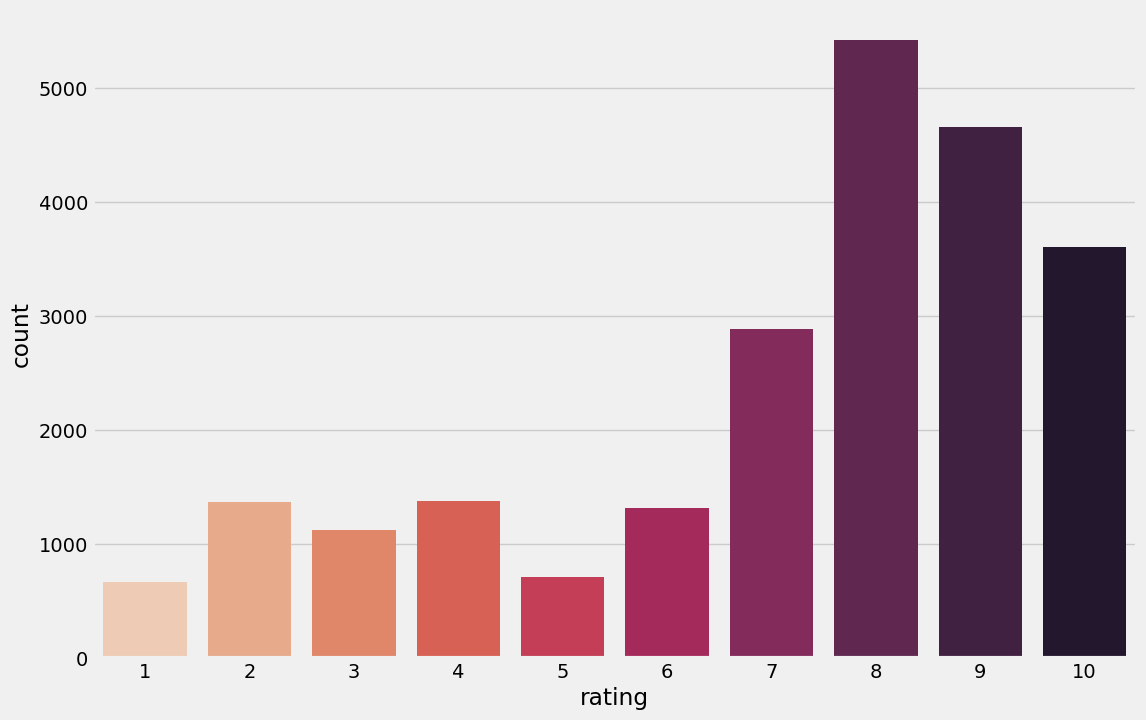

In [109]:
# 헤비유저들의 평점
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=train[(train['user_id'].isin(heavy_users_list))] , x='rating', palette='rocket_r')
plt.show()

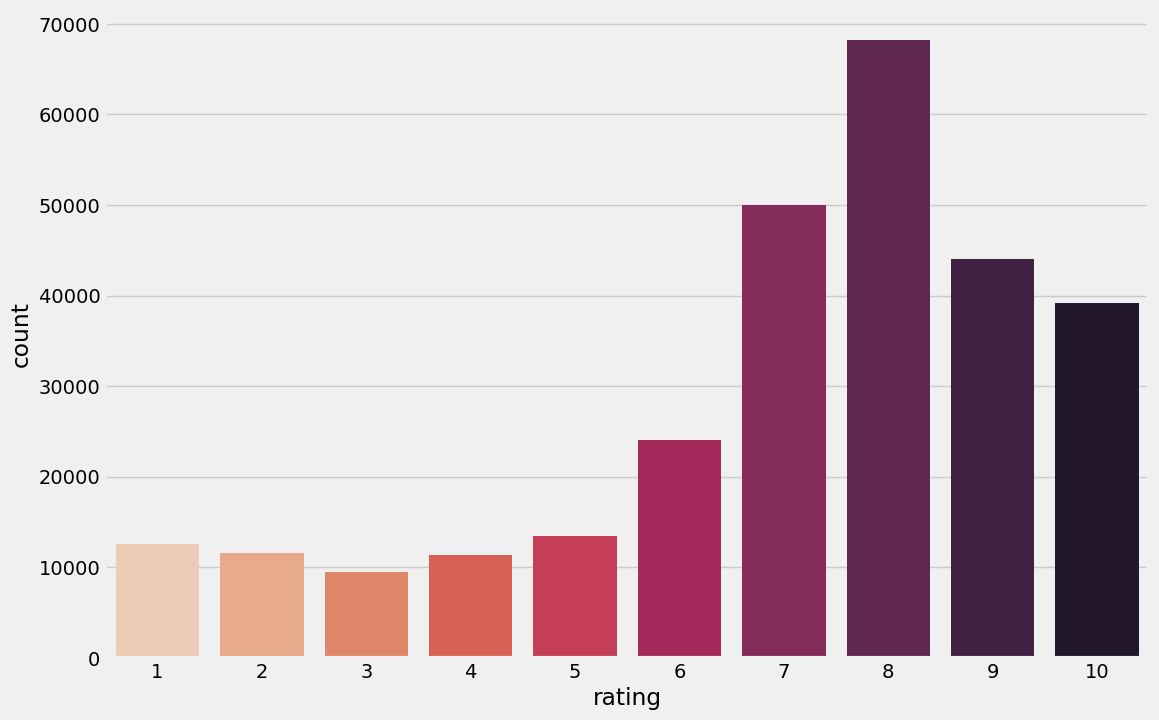

In [110]:
# 헤비 유저가 아닌 유저들
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=train[~(train['user_id'].isin(heavy_users_list))] , x='rating', palette='rocket_r')
plt.show()

비교가 조금 애매하므로 kdeplot 으로 겹쳐서 확인해보자

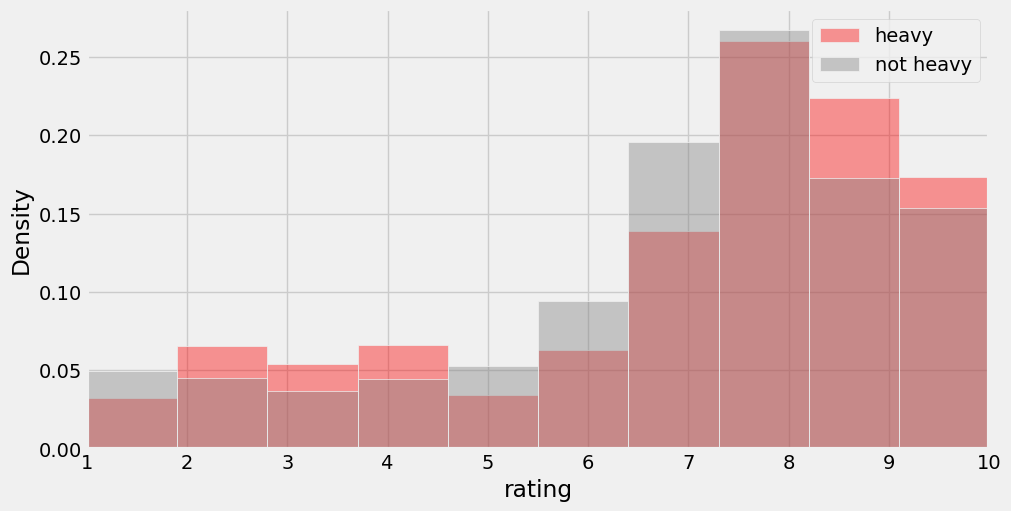

In [125]:
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

sns.histplot(data=train[(train['user_id'].isin(heavy_users_list))] , x='rating', ax=ax, stat='density', bins=10, color='red', alpha=0.4)
sns.histplot(data=train[~(train['user_id'].isin(heavy_users_list))] , x='rating', ax=ax, stat='density', bins=10, color='gray', alpha=0.4)
ax.set_xlim(1,10)
plt.legend(labels=["heavy", "not heavy"])
plt.show()

헤비 유저들은 뭔가 애매(?)한 평점을 내리지 않고 극과 극으로 평점을 내리는 듯 함

**헤비 유저의 여부가 생각보다 좋은 변수로 작용할 수도 있다고 생각**

# Merge

In [126]:
merge1 = train.merge(books, how='left', on='isbn')
data = merge1.merge(users, how='inner', on='user_id')
print('merge 결과 shape: ', data.shape)

merge 결과 shape:  (306795, 17)


In [127]:
set(train['isbn']) - set(books['isbn']) 

set()

정상적으로 잘 merge 되었다

### visualization

In [128]:
popular_book_list = data['book_title'].value_counts().sort_values(ascending=False)[:30].index
popular_book = data[data['book_title'].isin(popular_book_list)]

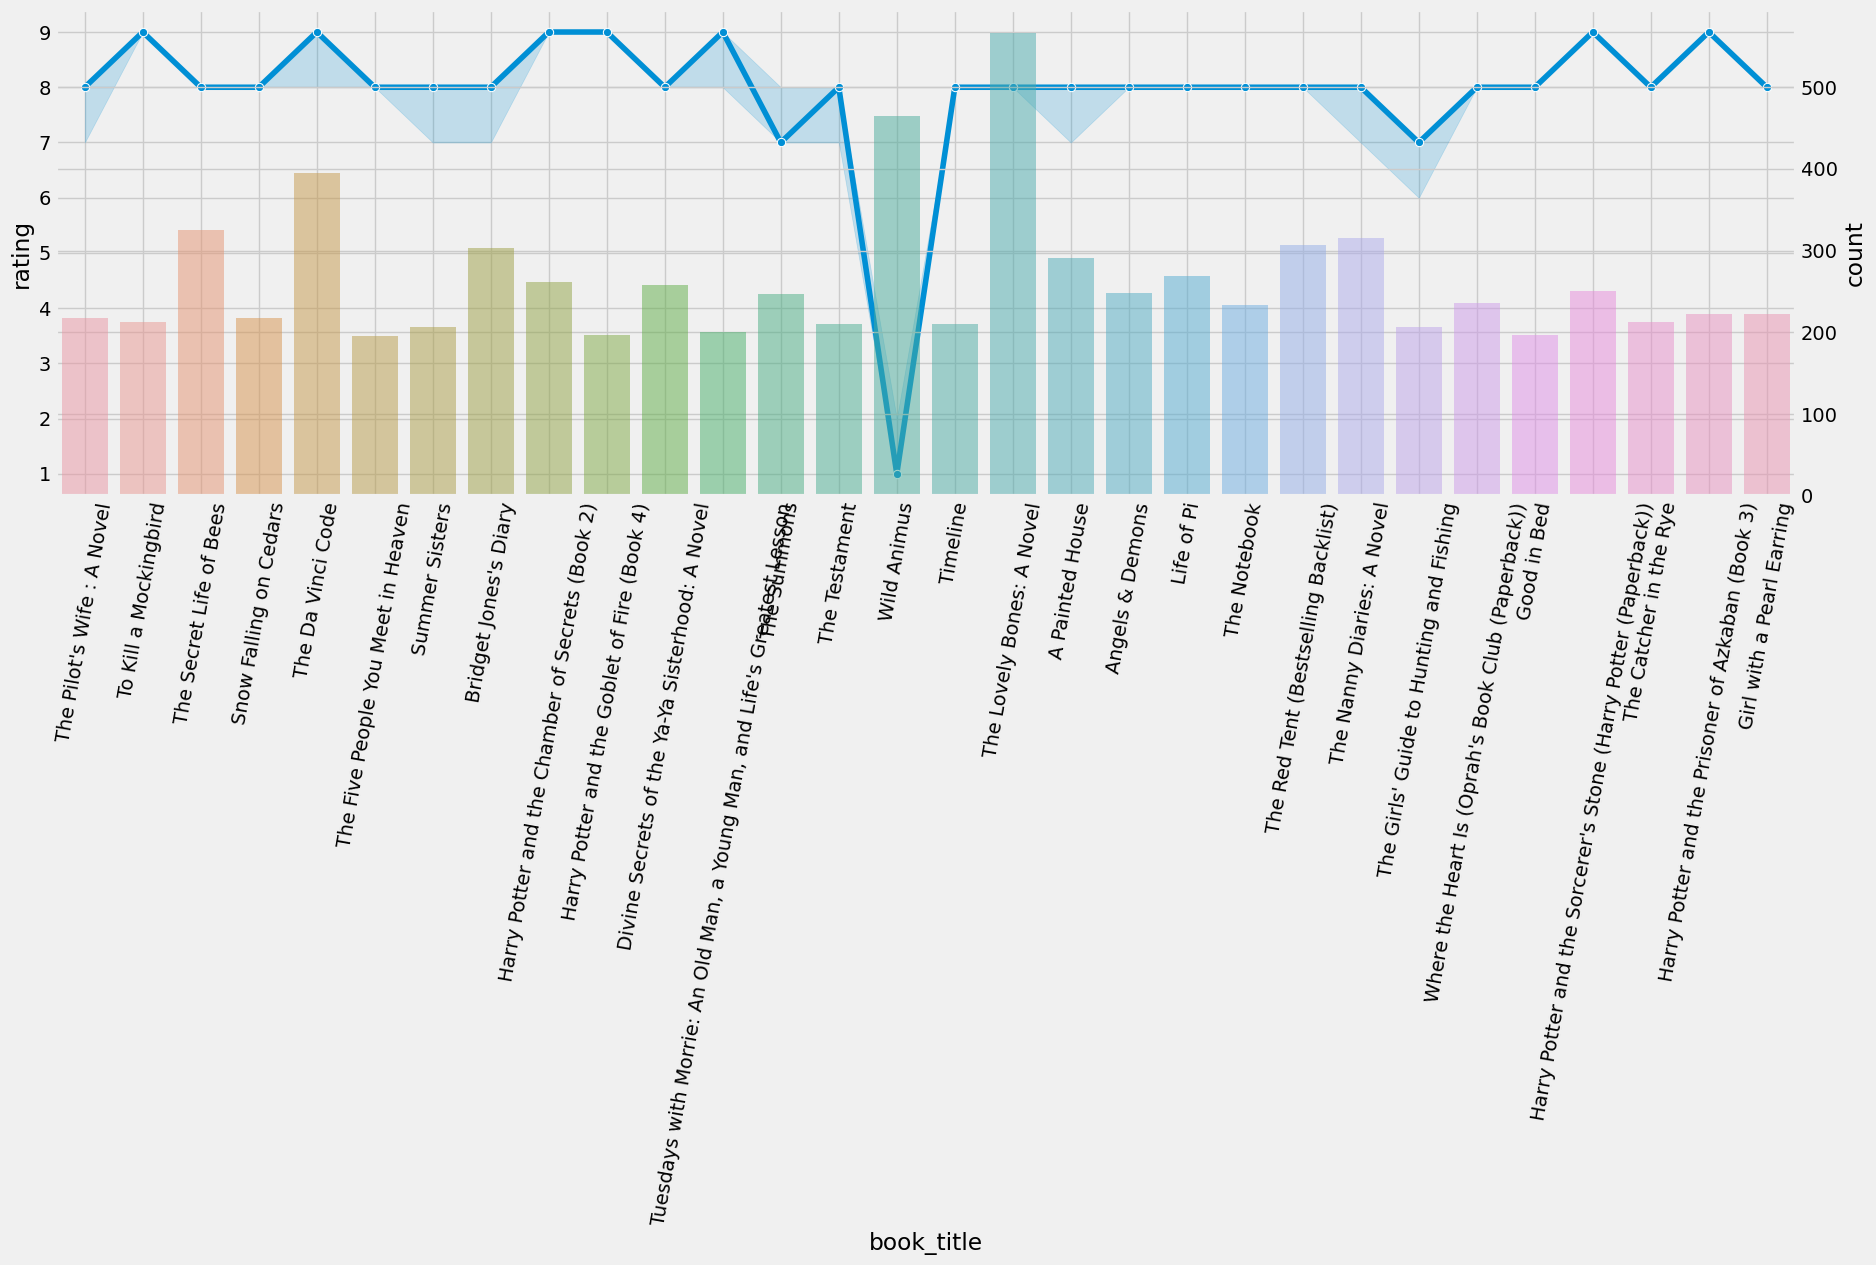

In [129]:
fig, ax1 = plt.subplots(figsize=(20,6))
plt.xticks(rotation=80)
sns.lineplot(data = popular_book,x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1)
ax2 = ax1.twinx()

sns.countplot(data=popular_book, x='book_title', alpha=0.5, ax=ax2)
plt.show()

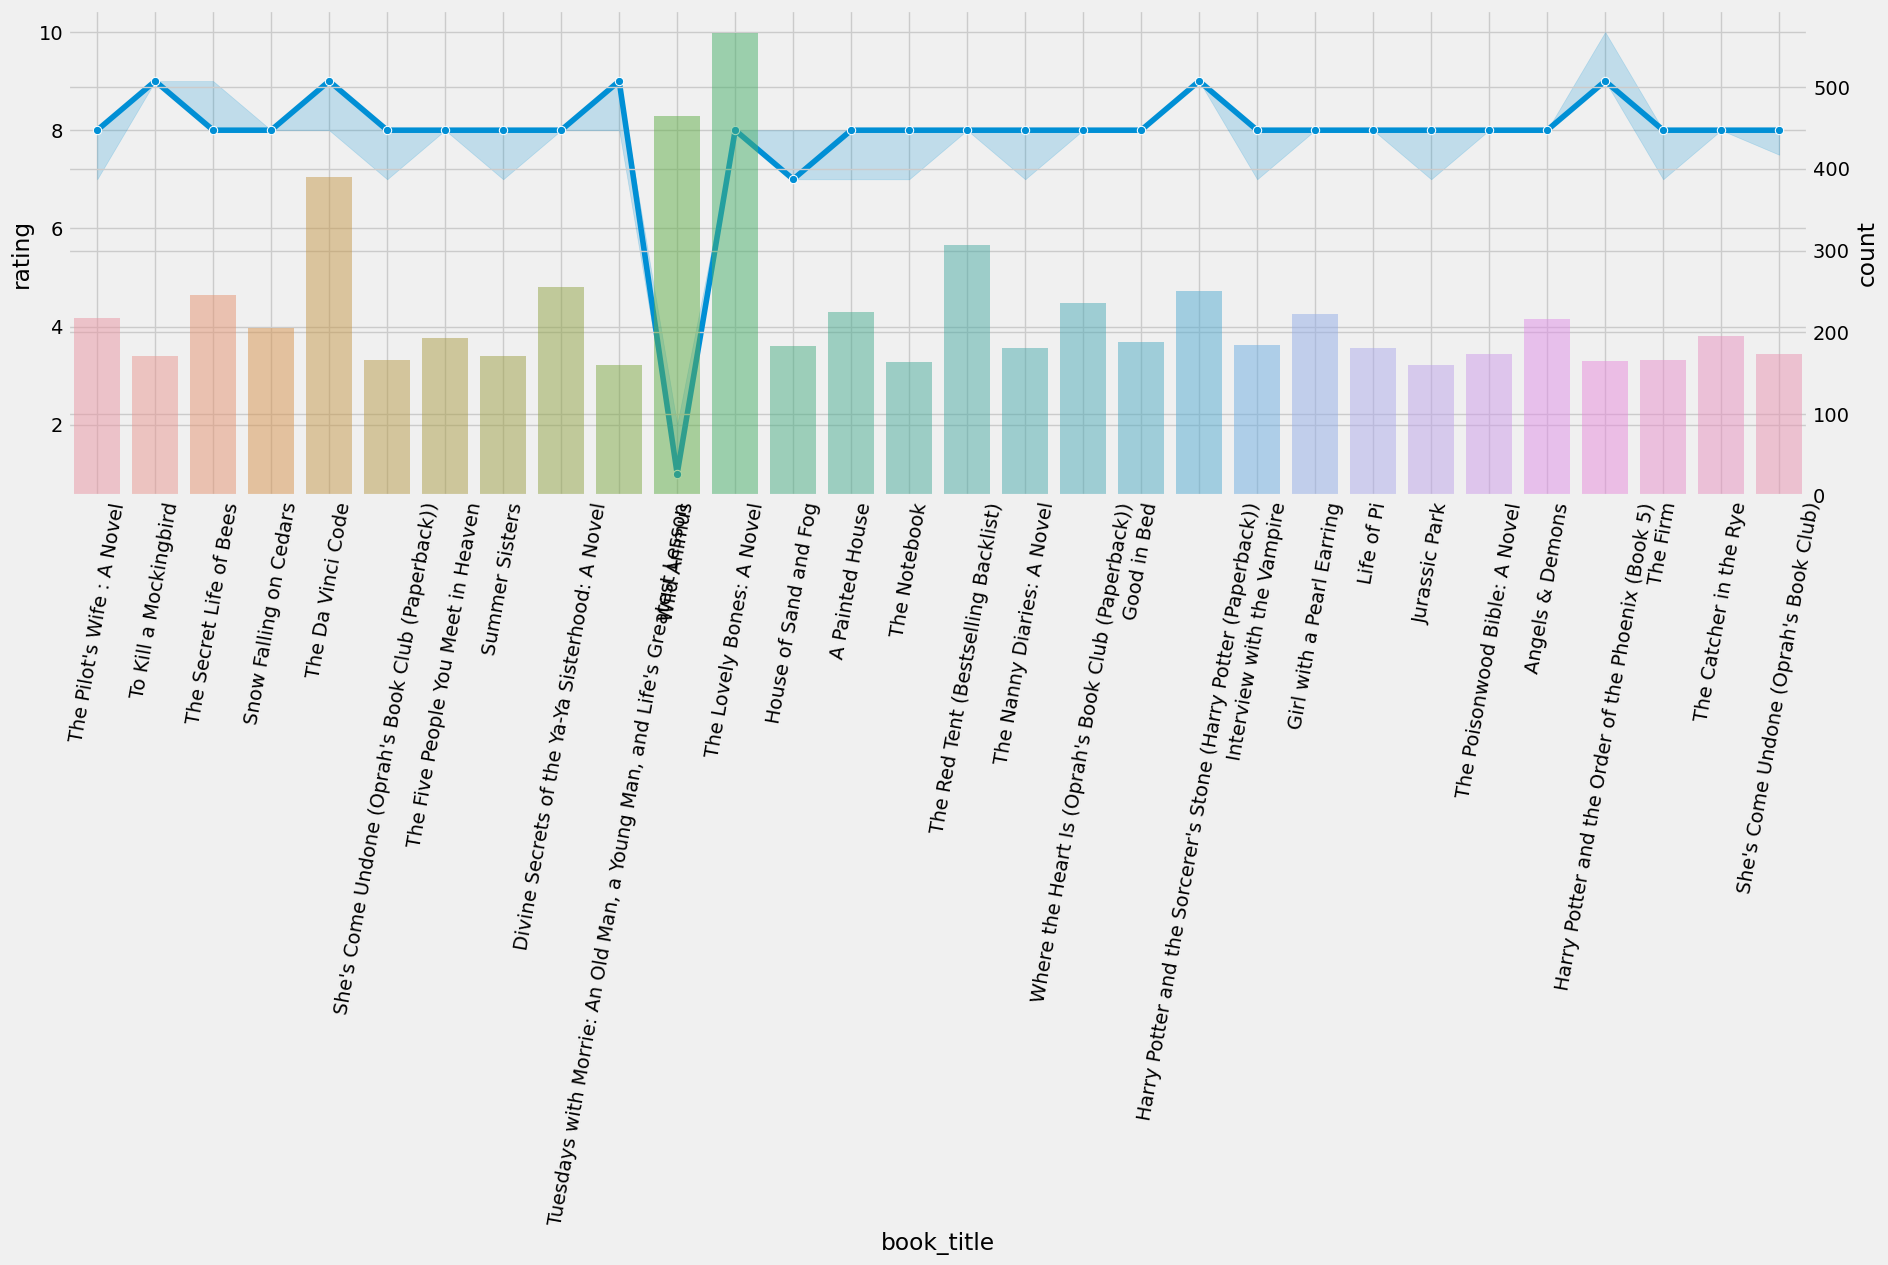

In [130]:
popular_book_list = data['isbn'].value_counts().sort_values(ascending=False)[:30].index
popular_book = data[data['isbn'].isin(popular_book_list)]

fig, ax1 = plt.subplots(figsize=(20,6))
plt.xticks(rotation=80)
sns.lineplot(data = popular_book,x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1)
ax2 = ax1.twinx()

sns.countplot(data=popular_book, x='book_title', alpha=0.5, ax=ax2)
plt.show()

isbn 을 기준으로 인기있는 책을 나누는 것과 책 제목으로 나누는 것이 다름 -> 이는 국가를 반영

이때, 평점 1 점을 주는 유저들의 영향이 매우 큼을 알 수 있음

**어쩌면 train 할 때 평점 1점을 제외하는 것도 전체적인 RMSE 를 줄이는 것에 도움이 될 수 있겠다는 생각이 듬**

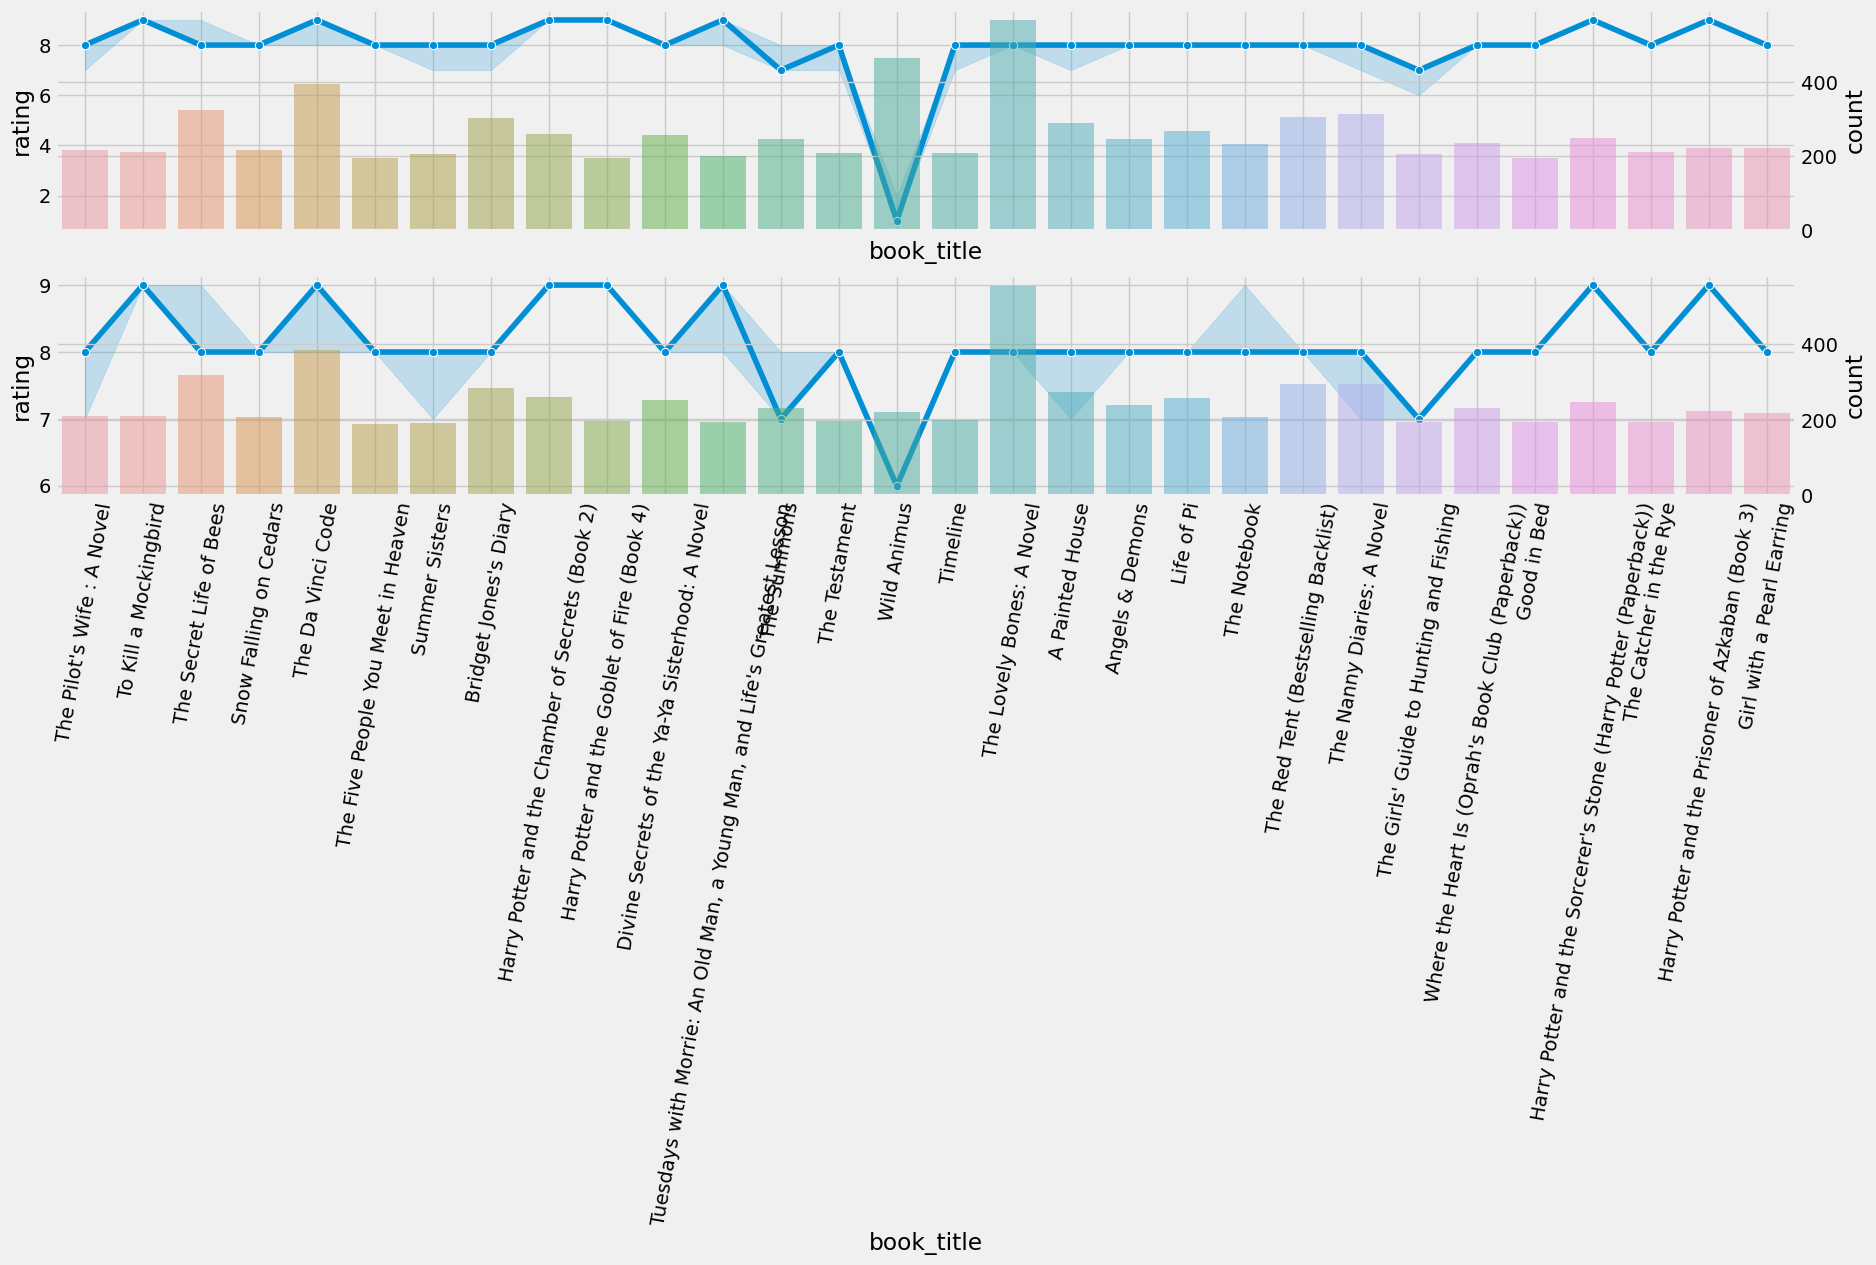

In [133]:
# book title을 사용했을떄
popular_book_list = data['book_title'].value_counts().sort_values(ascending=False)[:30].index
popular_book = data[data['book_title'].isin(popular_book_list)]
fig, ax1 = plt.subplots(2,1, figsize=(20,6))
plt.xticks(rotation=80)
plot1 = sns.lineplot(data = popular_book,x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1[0])
plot1 = sns.countplot(data=popular_book, x='book_title', alpha=0.5, ax=ax1[0].twinx())
plot1.set_xticklabels([])


plot2 = sns.lineplot(data = popular_book[popular_book['rating']>1],x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1[1])
plot2 = sns.countplot(data=popular_book[popular_book['rating']>1], x='book_title', alpha=0.5, ax=ax1[1].twinx())
plt.show()

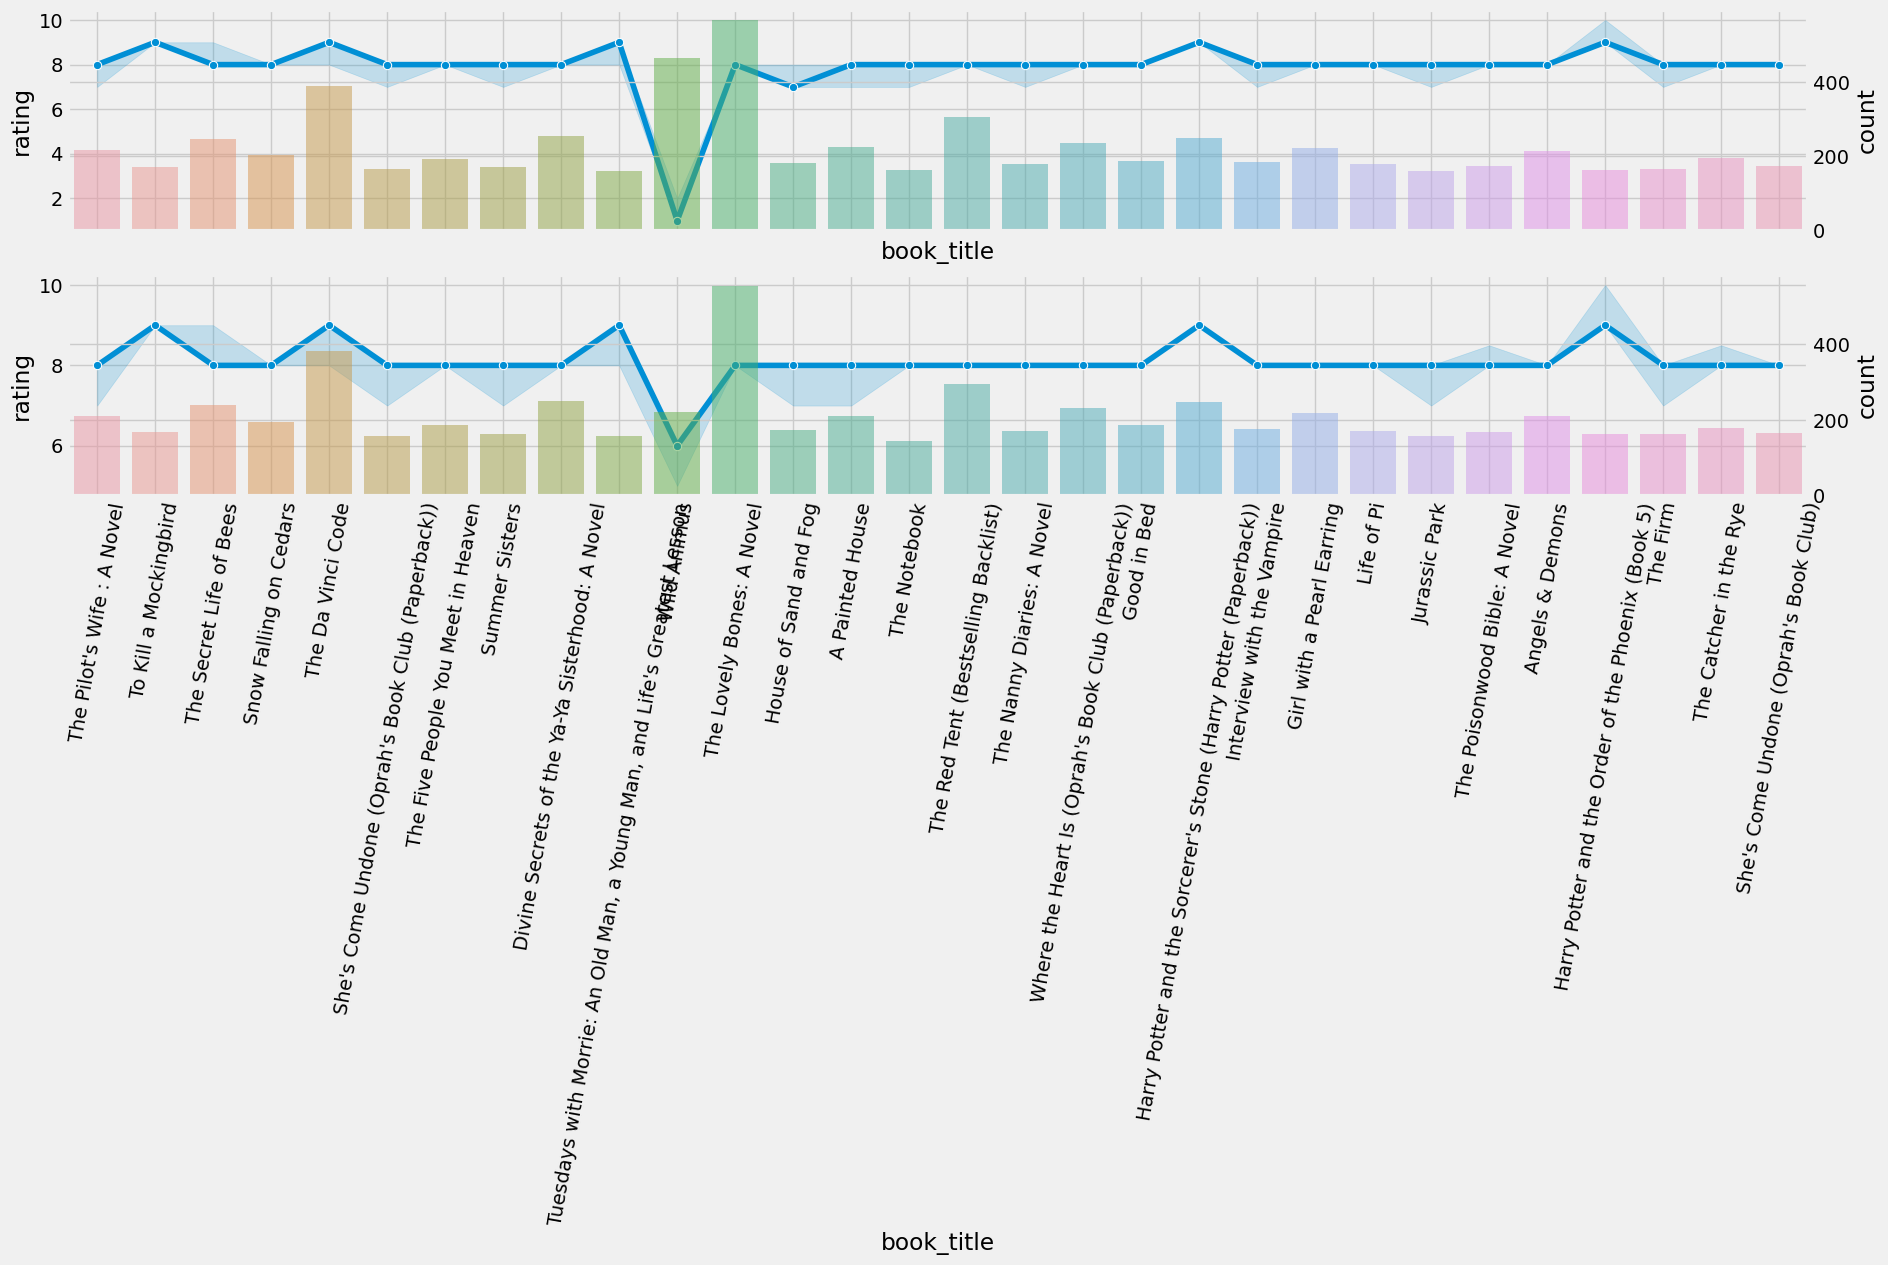

In [132]:
# isbn을 사용했을 때
popular_book_list = data['isbn'].value_counts().sort_values(ascending=False)[:30].index
popular_book = data[data['isbn'].isin(popular_book_list)]
fig, ax1 = plt.subplots(2,1, figsize=(20,6))
plt.xticks(rotation=80)
plot1 = sns.lineplot(data=popular_book,x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1[0])
plot1 = sns.countplot(data=popular_book, x='book_title', alpha=0.5, ax=ax1[0].twinx())
plot1.set_xticklabels([])

plot2 = sns.lineplot(data = popular_book[popular_book['rating']>1],x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1[1])
plot2 = sns.countplot(data=popular_book[popular_book['rating']>1], x='book_title', alpha=0.5, ax=ax1[1].twinx())
plt.show()


특정 값들을 제외하고는(평점 1점) 많이 읽힌 책들은 대개 평점이 8 점임을 알 수 있음

카테고리 별 점수 또한 확인해보자

In [134]:
popular_cate_list = data['category_high'].value_counts().sort_values(ascending=False)[:10].index
popular_cate = data[data['category_high'].isin(popular_cate_list)]

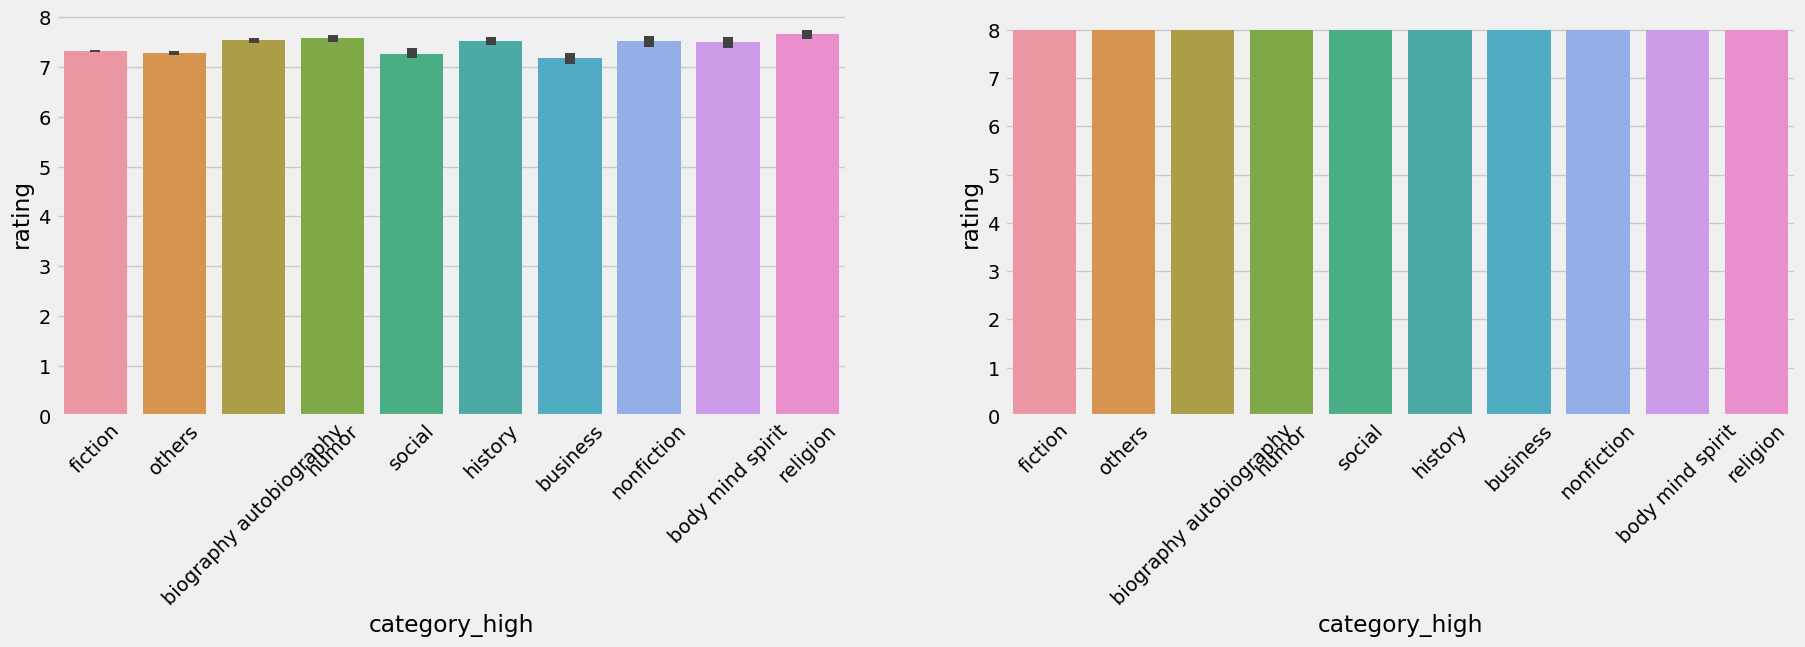

In [135]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

plot1 = sns.barplot(data=popular_cate[popular_cate['rating']>1], x='category_high', y='rating', estimator=np.mean, ax=ax[0], )
plot2 = sns.barplot(data=popular_cate[popular_cate['rating']>1], x='category_high', y='rating', estimator=np.median, ax=ax[1])
plot1.set_xticklabels(plot1.get_xticklabels(), rotation=45)
plot2.set_xticklabels(plot2.get_xticklabels(), rotation=45)
plt.show()

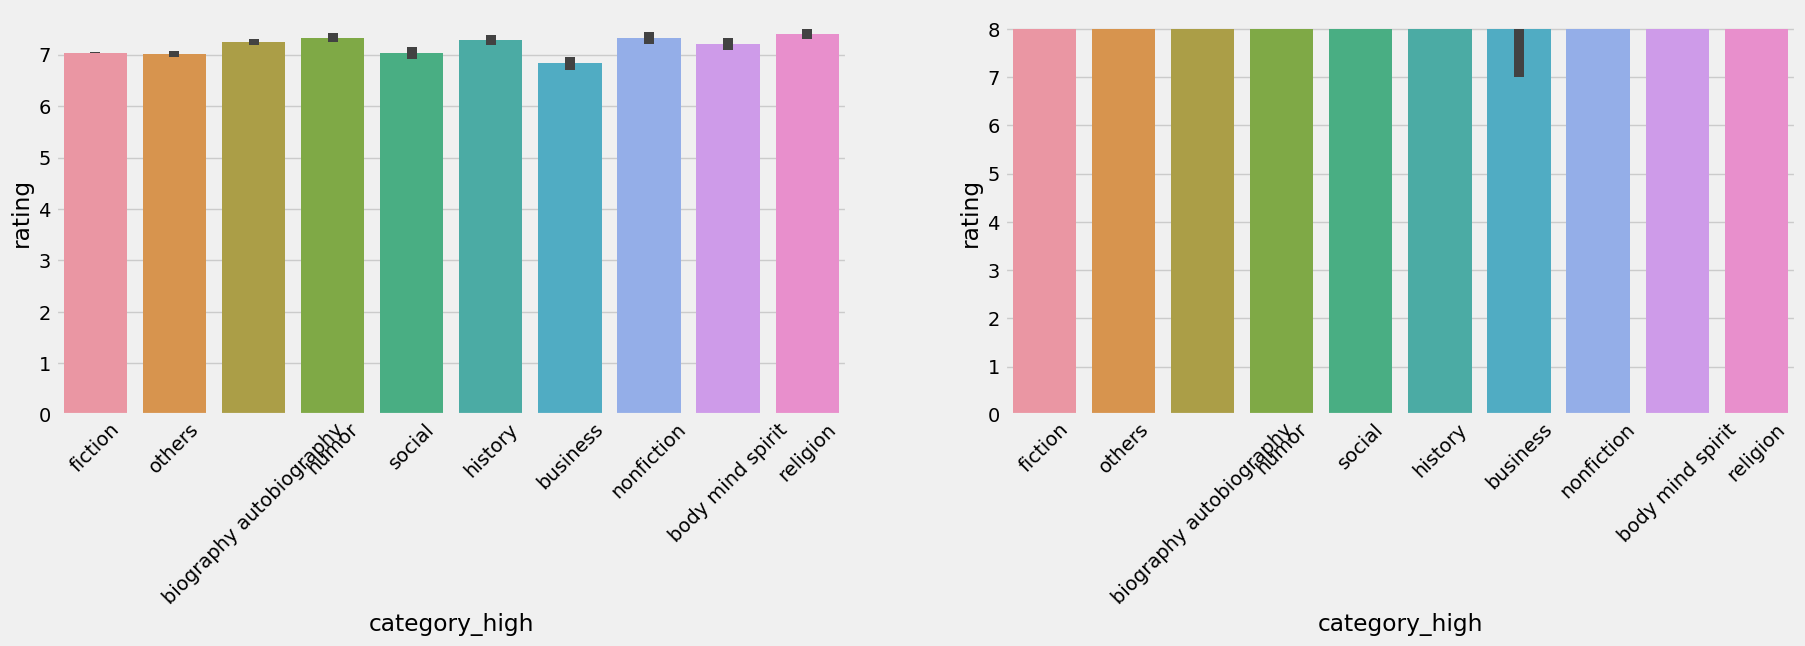

In [136]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

plot1 = sns.barplot(data=popular_cate, x='category_high', y='rating', estimator=np.mean, ax=ax[0], )
plot2 = sns.barplot(data=popular_cate, x='category_high', y='rating', estimator=np.median, ax=ax[1])
plot1.set_xticklabels(plot1.get_xticklabels(), rotation=45)
plot2.set_xticklabels(plot2.get_xticklabels(), rotation=45)
plt.show()

카테고리별 점수 차이는 없음